In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [3]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional,GRU
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import backend as K
import shutil,os
import pickle

In [4]:
df_final = pd.read_csv('Datos seleccionados/df_dia_sig_final_10.csv').reset_index(drop=True)
df_final

,Date,sma90 avg_transaction_value,wma30 avg_transaction_value,closing_price,dema7 opening_price,ema90 avg_transaction_value,tema30 highest_price,opening_price,tema7 closing_price,ema30 avg_transaction_value,dema90 avg_transaction_value,next_day_closing_price
0,2013-04-01,0.000000,0.001013,0.000561,0.000377,0.000000,0.000314,0.000388,0.000590,0.000750,0.000000,118.0
1,2013-04-02,0.000082,0.001185,0.000781,0.000469,0.000124,0.000409,0.000561,0.000769,0.000925,0.000180,135.0
2,2013-04-03,0.000169,0.001354,0.001049,0.000621,0.000247,0.000572,0.000781,0.001014,0.001095,0.000358,132.1
3,2013-04-04,0.000248,0.001499,0.001004,0.000833,0.000360,0.000699,0.001049,0.001111,0.001237,0.000518,142.3
4,2013-04-05,0.000328,0.001643,0.001164,0.000944,0.000474,0.000816,0.001004,0.001242,0.001377,0.000677,142.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3088,2021-09-14,0.962009,1.000000,0.740622,0.713871,0.987119,0.777173,0.707069,0.719939,1.000000,0.996045,48130.6
3089,2021-09-15,0.971827,0.992880,0.757213,0.724588,0.991312,0.776191,0.740477,0.740076,0.987087,0.996319,47748.0
3090,2021-09-16,0.982980,0.989533,0.751185,0.739332,0.997794,0.775406,0.757200,0.748003,0.979753,1.000000,47282.8
3091,2021-09-17,0.991883,0.974805,0.743856,0.746433,0.998428,0.773731,0.751149,0.747889,0.961515,0.995155,48306.7


In [5]:
def calcular_metricas(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

In [63]:
def plotear_resultados(y,ypred,title=None):    
    plt.figure(figsize=(15,6))
    plt.rcParams.update({'font.size': 22})
    plt.plot(y,label='Precio real')
    plt.plot(ypred,label='Prediccion')
    plt.legend()    
    plt.title(title)
    plt.show()

## Train Test Split

In [7]:
ventana_entr = 500
ventana_test = 100
splits_entr = []
splits_test = []
for i in tqdm(range(ventana_entr, len(df_final),ventana_test)):
    train_split = df_final[i-ventana_entr:i]
    test_split = df_final[i:i+ventana_test]
    splits_entr.append(train_split)
    splits_test.append(test_split)

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 52128.06it/s]


In [8]:
def visualizar_split(nro_batch,show_plot=True):
    df_final.plot(x='Date',y='next_day_closing_price',figsize=(15,6))
    for i in range(splits_entr[nro_batch].index[0],splits_entr[nro_batch].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(splits_test[nro_batch].index[0],splits_test[nro_batch].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Split de ventana temporal-{nro_batch+1}')
    if not os.path.exists('/content/plot'):
        os.makedirs('/content/plot')
        
    plt.savefig(f'/content/plot/Split de ventana temporal-{nro_batch+1}.png')
    plt.show()

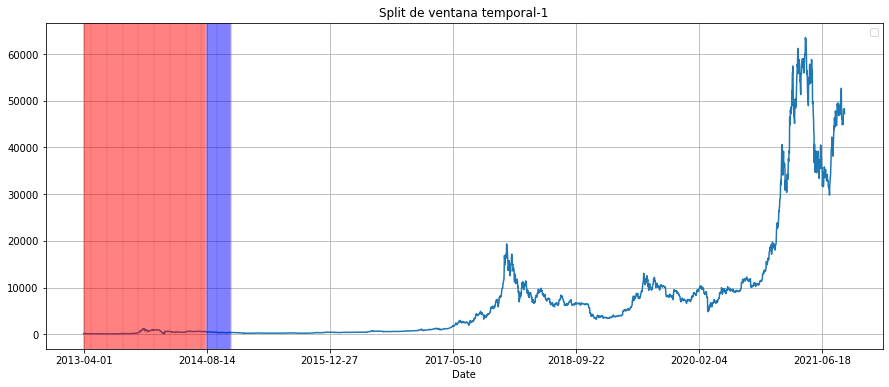

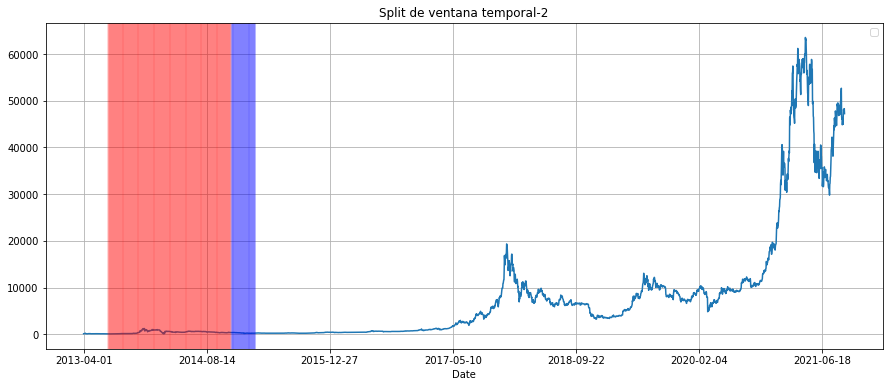

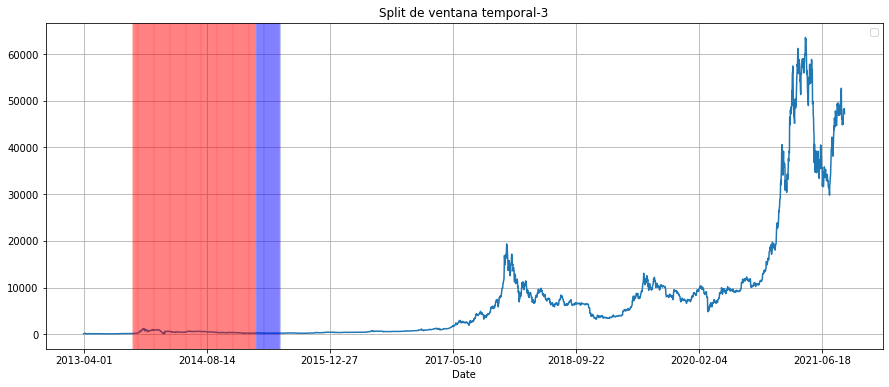

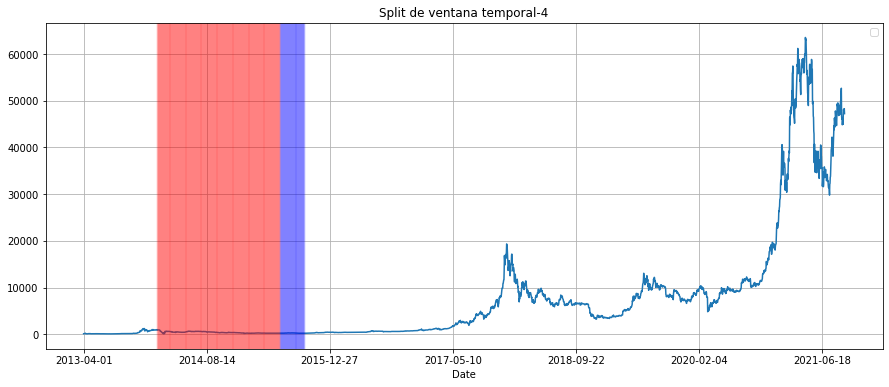

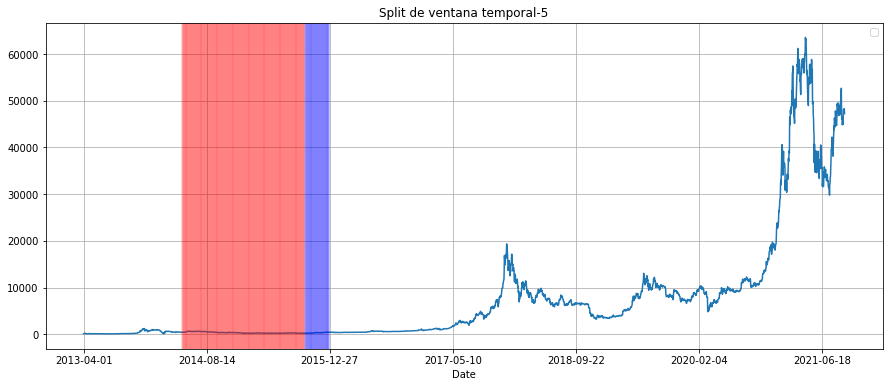

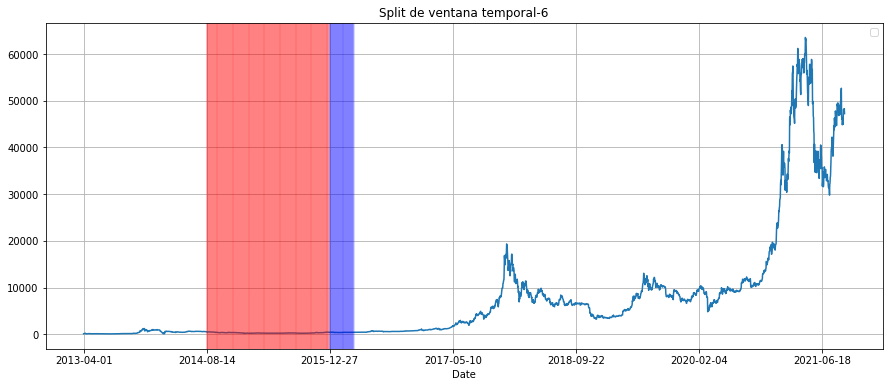

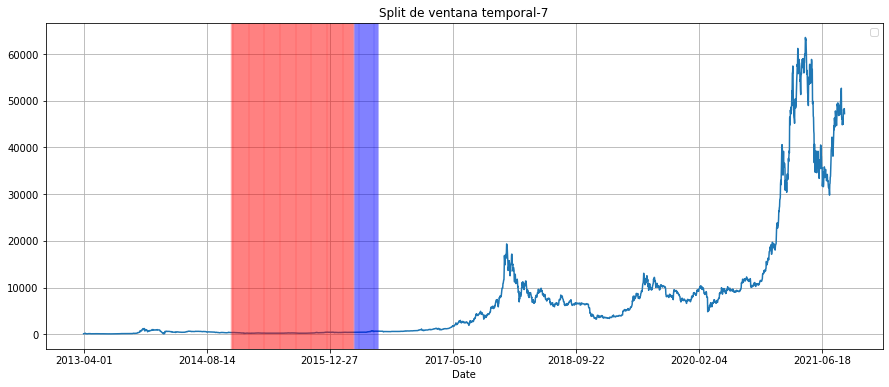

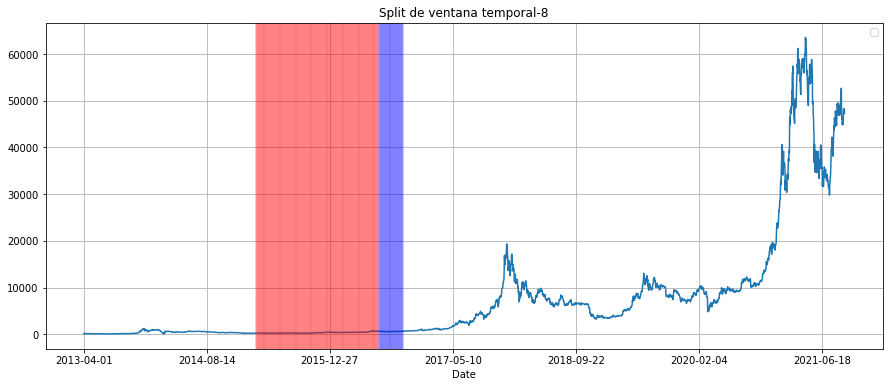

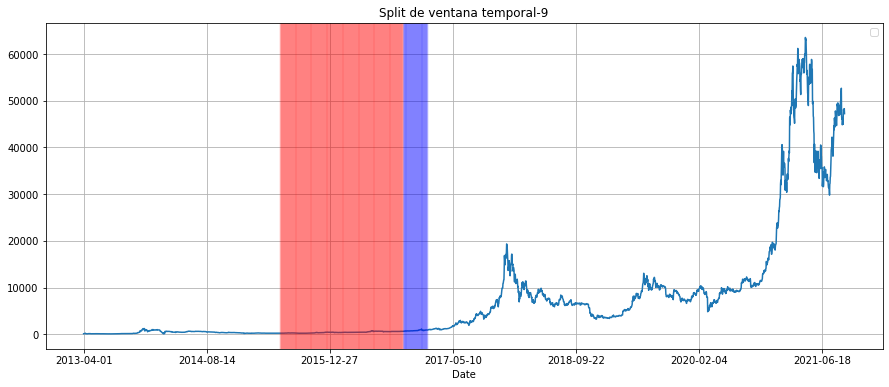

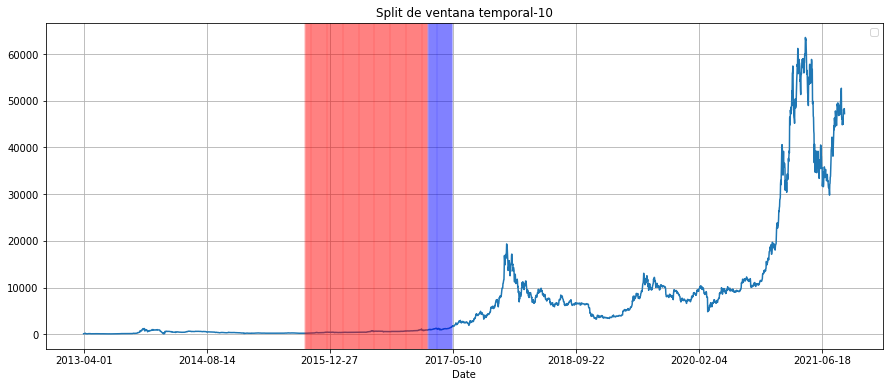

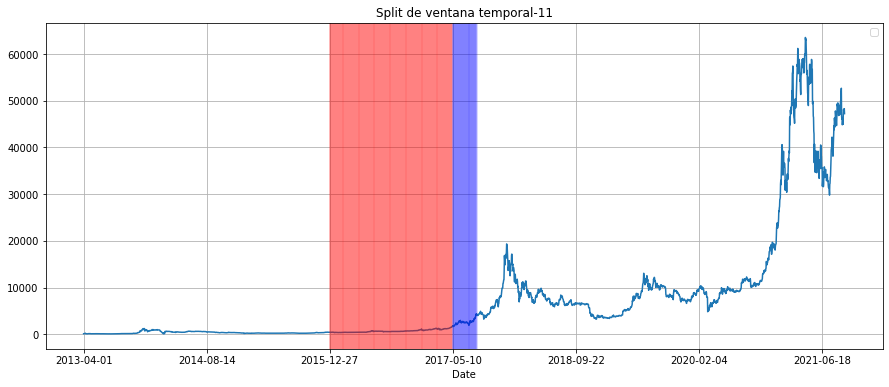

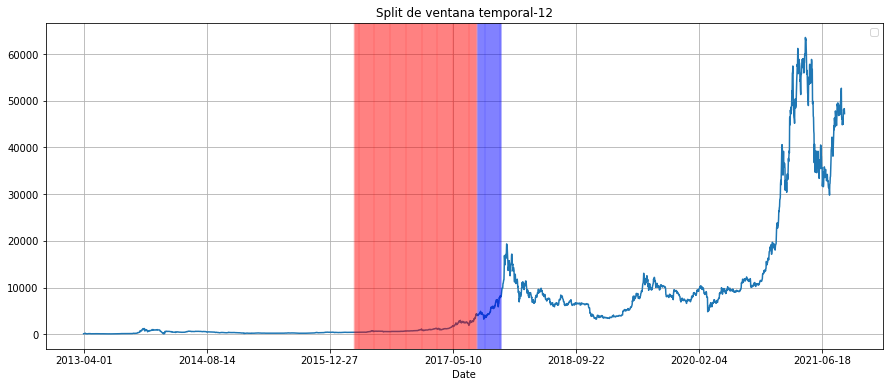

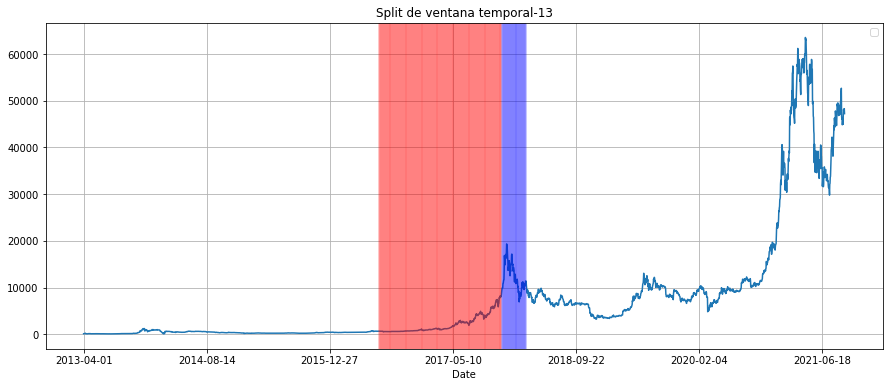

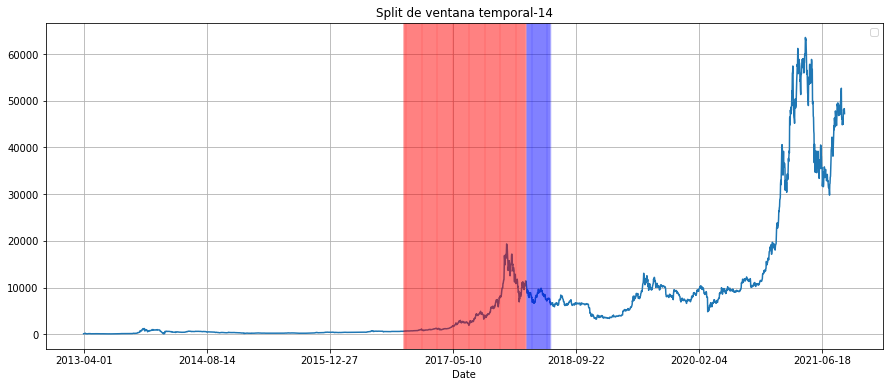

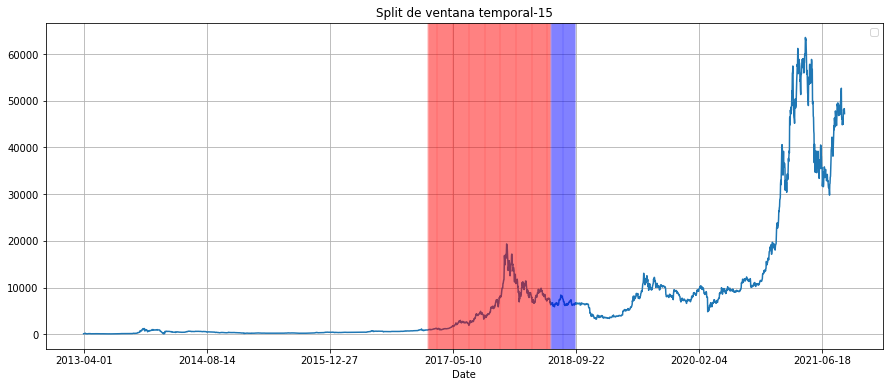

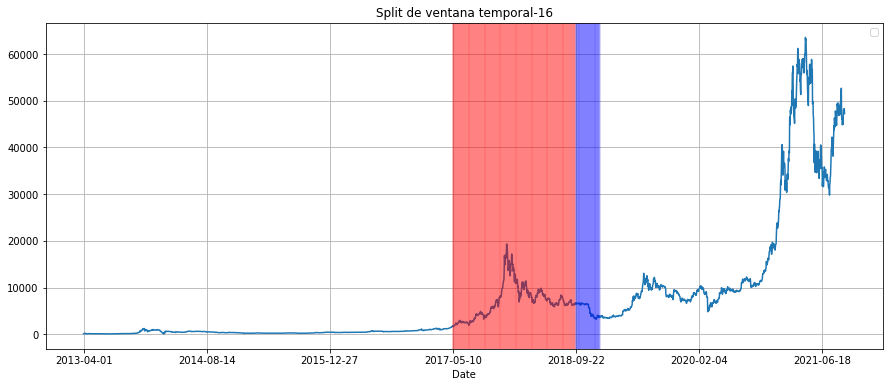

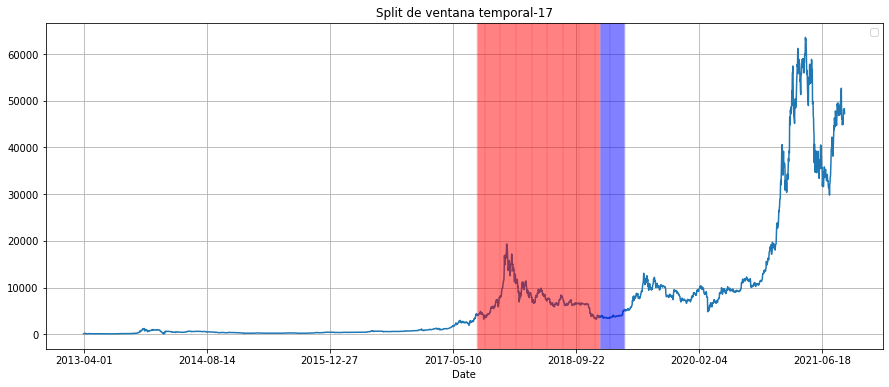

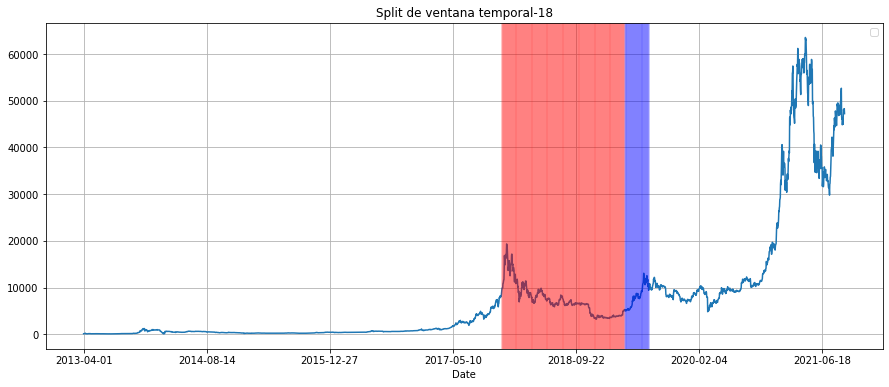

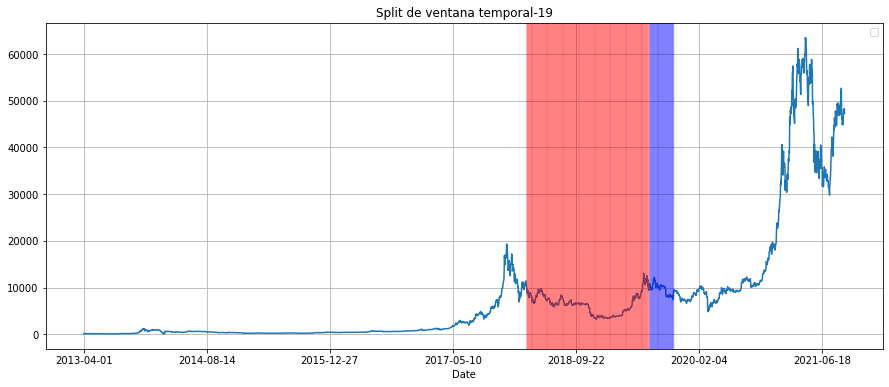

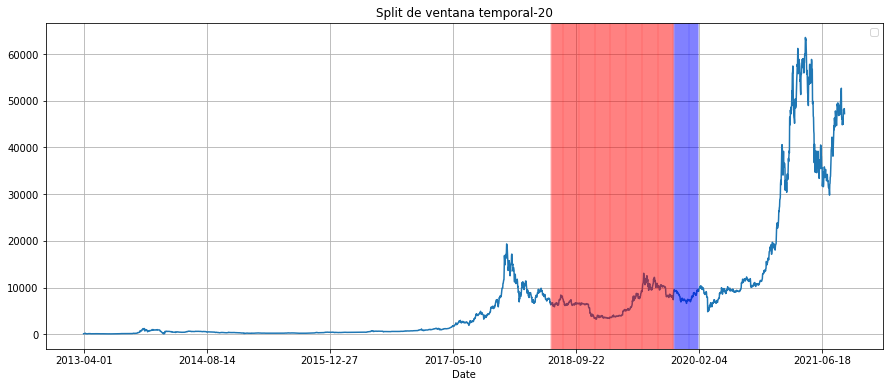

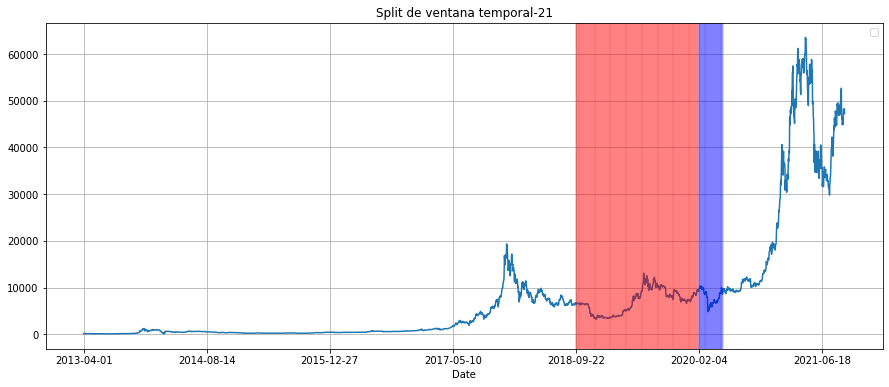

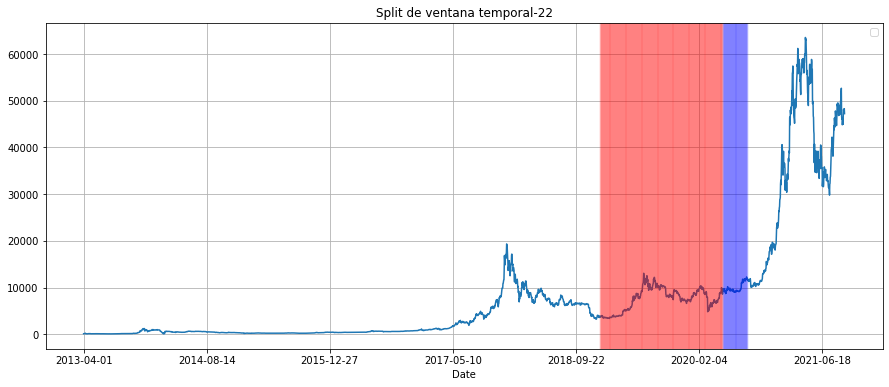

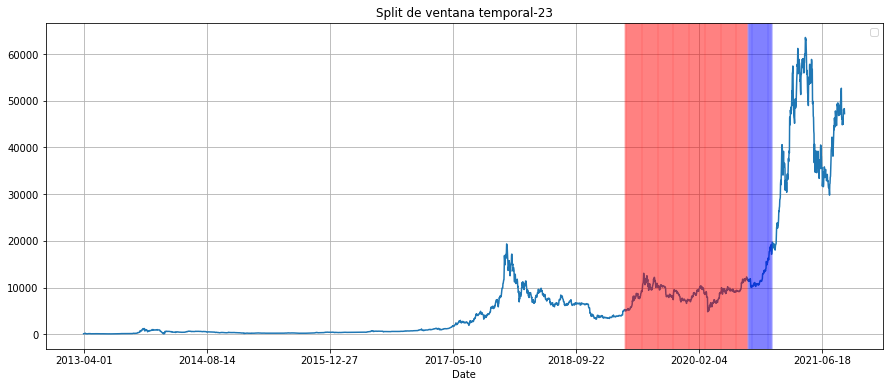

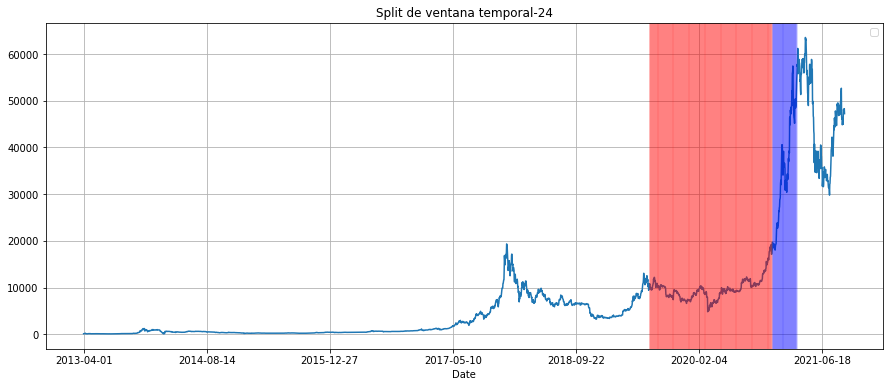

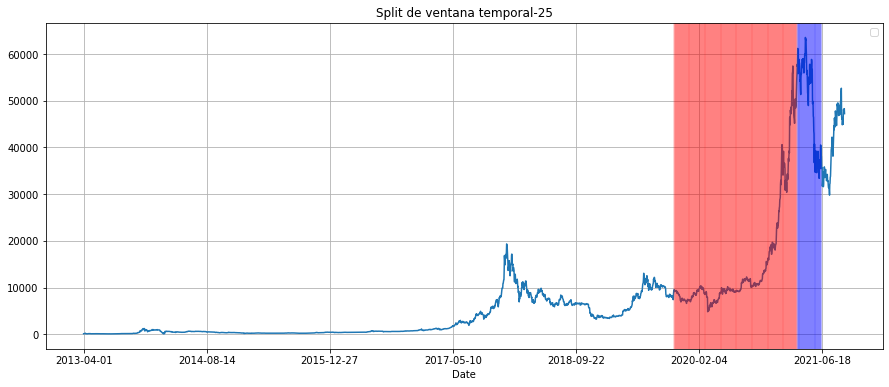

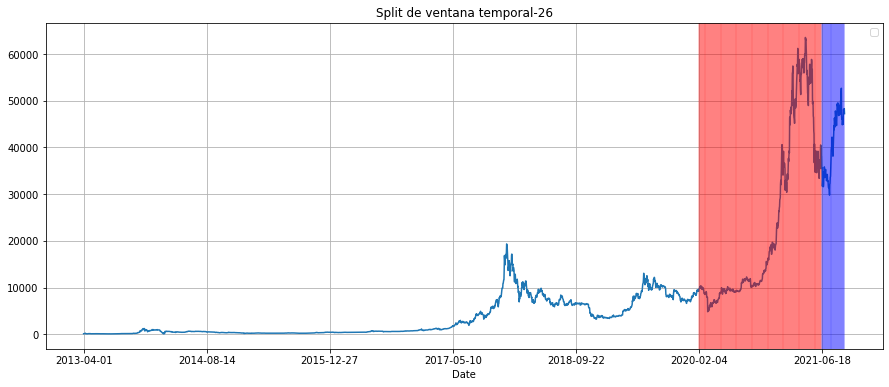

In [9]:
for i in range(len(splits_entr)):
    visualizar_split(i)

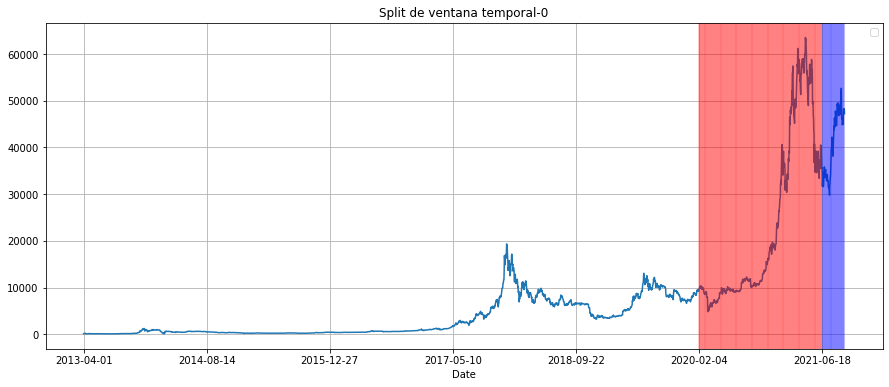

In [10]:
visualizar_split(-1)

In [11]:
import shutil
shutil.make_archive('plot', 'zip', '/content/plot')

'D:\\Desktop\\UCSP\\Proyecto de tesis II\\Implementación\\.temp\\traducido\\plot.zip'

# MODELOS BASE

## SVR

In [12]:
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_mae_train_array = []
svr_batch_rmse_train_array = []
svr_batch_mae_test_array = []
svr_batch_rmse_test_array = []

In [13]:
for i in tqdm(range(len(splits_entr))):
    Xtrain_split = splits_entr[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = splits_test[i].drop(['next_day_closing_price','Date'],axis=1).values
    ytrain_split = splits_entr[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = splits_test[i]['next_day_closing_price'].reset_index(drop=True).values
    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)
    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)
    MAE_train,RMSE_train = calcular_metricas(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calcular_metricas(ytest_split,ytest_pred)
    svr_date_array.extend(splits_test[i]['Date'])
    svr_y_test_array.extend(splits_test[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(splits_test[i]))
    svr_batch_id_array_result.append(i)
    svr_batch_mae_train_array.append(MAE_train)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_mae_test_array.append(MAE_test)
    svr_batch_rmse_test_array.append(RMSE_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 43.66it/s]


In [14]:
svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['mae_train'] = svr_batch_mae_train_array
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['mae_test'] = svr_batch_mae_test_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

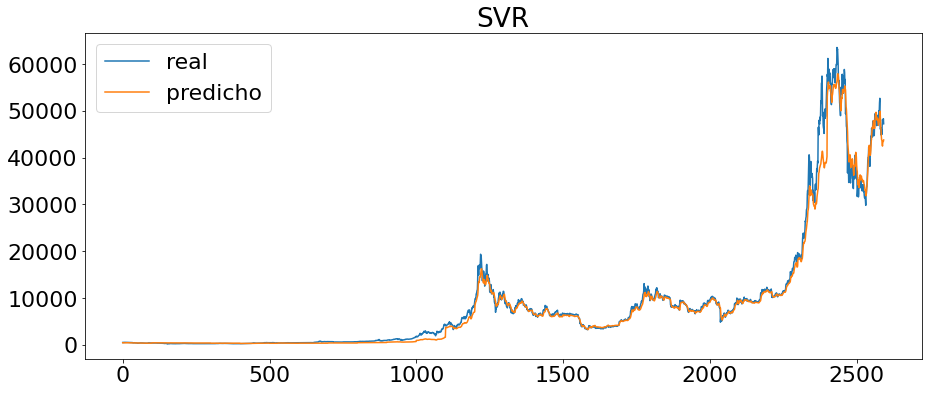

In [15]:
plotear_resultados(svr_y_test_array,svr_y_test_pred_array,'SVR')

In [16]:
svr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,120.367930,143.137339,37.557171,47.589100
1,1,119.315354,151.550344,100.107735,107.562541
2,2,111.801893,146.425888,130.120946,130.778461
3,3,94.885977,118.019405,81.225696,83.626687
4,4,82.535137,113.764954,46.950195,56.673283
5,5,53.435309,70.804247,78.105413,84.732816
6,6,41.612811,52.430544,203.685458,228.408946
7,7,62.762662,95.314978,238.163164,239.792159
8,8,95.733579,119.221376,344.970803,355.841261
9,9,123.549507,157.757281,581.301647,598.117689


In [17]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,239.838546
rmse_train,380.781326
mae_test,738.697268
rmse_test,898.226368


## Regresion Lineal

In [18]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_mae_train_array = []
lr_batch_rmse_train_array = []
lr_batch_mae_test_array = []
lr_batch_rmse_test_array = []

In [19]:
for i in tqdm(range(len(splits_entr))):
    Xtrain_split = splits_entr[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = splits_test[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = splits_entr[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = splits_test[i]['next_day_closing_price'].reset_index(drop=True).values
    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)

    
    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)
    MAE_train,RMSE_train = calcular_metricas(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calcular_metricas(ytest_split,ytest_pred)
    lr_date_array.extend(splits_test[i]['Date'])
    lr_y_test_array.extend(splits_test[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(splits_test[i]))
    lr_batch_id_array_result.append(i)
    lr_batch_mae_train_array.append(MAE_train)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_mae_test_array.append(MAE_test)
    lr_batch_rmse_test_array.append(RMSE_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 42.31it/s]


In [20]:
lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

In [21]:
lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['mae_train'] = lr_batch_mae_train_array
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['mae_test'] = lr_batch_mae_test_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

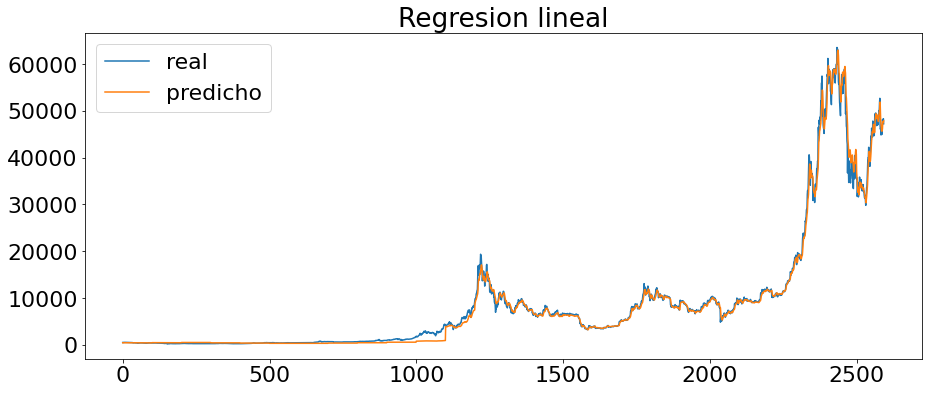

In [22]:
plotear_resultados(lr_y_test_array,lr_y_test_pred_array,'Regresion lineal')

In [23]:
lr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,212.500105,242.216252,45.869376,52.448298
1,1,169.185911,213.085925,154.078273,162.072189
2,2,161.835916,204.071654,238.008009,238.702998
3,3,135.330843,161.079437,154.276822,155.914987
4,4,114.894400,136.401390,67.823791,78.480885
5,5,67.501522,80.042458,105.760370,107.944678
6,6,66.558694,74.661248,230.783099,254.070939
7,7,101.967360,123.149149,253.818283,255.632769
8,8,117.823545,143.265722,375.917215,388.919717
9,9,153.489062,180.147068,632.430276,653.226613


In [24]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,250.754017
rmse_train,383.962766
mae_test,563.795056
rmse_test,692.260413


## LSTM

### Callbacks

#### EarlyStopping

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=100,verbose=100,mode='min')

####  Learning Rate Scheduler

In [39]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def cambiar_tasa_aprendizaje(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

In [40]:
lrschedule=LearningRateScheduler(cambiar_tasa_aprendizaje, verbose=1)

In [41]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=6,verbose=1,mode='min')

In [42]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Modelo

In [64]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = LSTM(400, return_sequences=True,activation='relu',name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)

lstm_2 = LSTM(500, return_sequences=True,name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)

output_layer = Dense(1,name='output_layer')(dropout_2)

In [65]:
model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [66]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 10)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 400)            657600    
                                                                 
 dropout_1 (Dropout)         (None, 1, 400)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 500)            1802000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 500)            0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              501       
                                                                 
Total params: 2,460,101
Trainable params: 2,460,101
Non-tra

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [68]:
lstm_date_array = []
lstm_y_test_array = []
lstm_y_test_pred_array = []
lstm_batch_id_array = []
lstm_batch_id_array_result = []
lstm_batch_mae_train_array = []
lstm_batch_rmse_train_array = []
lstm_batch_mae_test_array = []
lstm_batch_rmse_test_array = []

In [71]:
for i in range(len(splits_entr)):
    print(f'Nro Batch. {i+1} of {len(splits_entr)}')
    print('Entrenar data desde',splits_entr[i]['Date'].iloc[0],'-',splits_entr[i]['next_day_closing_price'].min(),
          'to',splits_entr[i]['Date'].iloc[-1],'-',splits_entr[i]['next_day_closing_price'].max())
    
    print('Entrenar data desde',splits_test[i]['Date'].iloc[0],'-',splits_test[i]['next_day_closing_price'].min(),
          'to',splits_test[i]['Date'].iloc[-1],'-',splits_test[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = splits_entr[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = splits_test[i].drop(['next_day_closing_price','Date'],axis=1).values
    ytrain_split = splits_entr[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = splits_test[i]['next_day_closing_price'].reset_index(drop=True).values
    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))
    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2
            ,callbacks = [reduce_lr,lrschedule,earlystop])
    
    model.save(f'LSTM/lstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calcular_metricas(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calcular_metricas(ytest_split,ytest_pred)
    lstm_date_array.extend(splits_test[i]['Date'])
    lstm_y_test_array.extend(splits_test[i]['next_day_closing_price'])
    lstm_y_test_pred_array.extend((ytest_pred.flatten()))
    lstm_batch_id_array.extend([i]*len(splits_test[i]))
    lstm_batch_id_array_result.append(i)
    lstm_batch_mae_train_array.append(MAE_train)
    lstm_batch_rmse_train_array.append(RMSE_train)
    lstm_batch_mae_test_array.append(MAE_test)
    lstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

Nro Batch. 1 of 26
Entrenar data desde 2013-04-01 - 68.4 to 2014-08-13 - 1237.6
Entrenar data desde 2014-08-14 - 322.5 to 2014-11-21 - 522.0

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 1s - loss: 411.5545 - root_mean_squared_error: 507.5536 - mae: 412.0545 - lr: 0.0010 - 1s/epoch - 90ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 411.0776 - root_mean_squared_error: 504.7728 - mae: 411.5776 - lr: 0.0010 - 155ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 409.6241 - root_mean_squared_error: 504.7583 - mae: 410.1241 - lr: 0.0010 - 153ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 405.7167 - root_mean_squared_error: 500.0671 - mae: 406.2167 - lr: 0.0010 - 156ms/epoch - 10ms/step

Epoch 00005: Lear


Epoch 00038: LearningRateScheduler setting learning rate to 0.0008681255858391523.
Epoch 38/500
16/16 - 0s - loss: 277.3038 - root_mean_squared_error: 361.1163 - mae: 277.8036 - lr: 8.6813e-04 - 165ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008681255858391523.
Epoch 39/500
16/16 - 0s - loss: 276.8685 - root_mean_squared_error: 359.7036 - mae: 277.3682 - lr: 8.6813e-04 - 159ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0008507630741223693.
Epoch 40/500
16/16 - 0s - loss: 276.4756 - root_mean_squared_error: 356.7774 - mae: 276.9754 - lr: 8.5076e-04 - 155ms/epoch - 10ms/step

Epoch 00041: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 41/500
16/16 - 0s - loss: 276.2049 - root_mean_squared_error: 358.3325 - mae: 276.7046 - lr: 8.5076e-04 - 161ms/epoch - 10ms/step

Epoch 00042: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 42/500
16/16 - 0s - loss: 275.

16/16 - 0s - loss: 268.6433 - root_mean_squared_error: 326.5858 - mae: 269.1432 - lr: 7.3857e-04 - 158ms/epoch - 10ms/step

Epoch 00076: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 76/500
16/16 - 0s - loss: 268.5599 - root_mean_squared_error: 325.1663 - mae: 269.0598 - lr: 7.3857e-04 - 156ms/epoch - 10ms/step

Epoch 00077: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 77/500
16/16 - 0s - loss: 268.4041 - root_mean_squared_error: 325.3958 - mae: 268.9040 - lr: 7.3857e-04 - 156ms/epoch - 10ms/step

Epoch 00078: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 78/500
16/16 - 0s - loss: 268.2877 - root_mean_squared_error: 324.0052 - mae: 268.7877 - lr: 7.3857e-04 - 157ms/epoch - 10ms/step

Epoch 00079: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 79/500
16/16 - 0s - loss: 268.1820 - root_mean_squared_error: 322.2463 - mae: 268.6819 - lr: 7.3857e-04 - 154ms/epoch - 10ms/st


Epoch 00113: LearningRateScheduler setting learning rate to 0.0006411707145161927.
Epoch 113/500
16/16 - 0s - loss: 263.7086 - root_mean_squared_error: 305.2732 - mae: 264.2086 - lr: 6.4117e-04 - 153ms/epoch - 10ms/step

Epoch 00114: LearningRateScheduler setting learning rate to 0.0006411707145161927.
Epoch 114/500
16/16 - 0s - loss: 263.7470 - root_mean_squared_error: 305.3309 - mae: 264.2469 - lr: 6.4117e-04 - 153ms/epoch - 10ms/step

Epoch 00115: LearningRateScheduler setting learning rate to 0.0006283473002258688.
Epoch 115/500
16/16 - 0s - loss: 263.5058 - root_mean_squared_error: 304.6889 - mae: 264.0057 - lr: 6.2835e-04 - 154ms/epoch - 10ms/step

Epoch 00116: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 116/500
16/16 - 0s - loss: 263.3398 - root_mean_squared_error: 304.8419 - mae: 263.8398 - lr: 6.2835e-04 - 156ms/epoch - 10ms/step

Epoch 00117: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 117/500
16/16 - 0s - loss:


Epoch 00150: LearningRateScheduler setting learning rate to 0.0005345746187958866.
Epoch 150/500
16/16 - 0s - loss: 260.5627 - root_mean_squared_error: 296.2279 - mae: 261.0625 - lr: 5.3457e-04 - 155ms/epoch - 10ms/step

Epoch 00151: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 151/500
16/16 - 0s - loss: 260.6505 - root_mean_squared_error: 296.8225 - mae: 261.1505 - lr: 5.3457e-04 - 153ms/epoch - 10ms/step

Epoch 00152: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 152/500
16/16 - 0s - loss: 260.3599 - root_mean_squared_error: 295.0808 - mae: 260.8598 - lr: 5.3457e-04 - 160ms/epoch - 10ms/step

Epoch 00153: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 153/500
16/16 - 0s - loss: 260.3077 - root_mean_squared_error: 296.3942 - mae: 260.8076 - lr: 5.3457e-04 - 159ms/epoch - 10ms/step

Epoch 00154: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 154/500
16/16 - 0s - loss:


Epoch 00186: LearningRateScheduler setting learning rate to 0.00043678635847754776.
Epoch 186/500
16/16 - 0s - loss: 258.9027 - root_mean_squared_error: 293.9634 - mae: 259.4027 - lr: 4.3679e-04 - 158ms/epoch - 10ms/step

Epoch 00187: LearningRateScheduler setting learning rate to 0.00043678635847754776.
Epoch 187/500
16/16 - 0s - loss: 259.0233 - root_mean_squared_error: 294.1279 - mae: 259.5232 - lr: 4.3679e-04 - 156ms/epoch - 10ms/step

Epoch 00188: LearningRateScheduler setting learning rate to 0.00043678635847754776.
Epoch 188/500
16/16 - 0s - loss: 258.8722 - root_mean_squared_error: 295.0649 - mae: 259.3722 - lr: 4.3679e-04 - 159ms/epoch - 10ms/step

Epoch 00189: LearningRateScheduler setting learning rate to 0.00043678635847754776.
Epoch 189/500
16/16 - 0s - loss: 258.7210 - root_mean_squared_error: 294.8421 - mae: 259.2210 - lr: 4.3679e-04 - 166ms/epoch - 10ms/step

Epoch 00190: LearningRateScheduler setting learning rate to 0.0004280506313079968.
Epoch 190/500
16/16 - 0s - l


Epoch 00222: LearningRateScheduler setting learning rate to 0.0003427535993978381.
Epoch 222/500
16/16 - 0s - loss: 258.0496 - root_mean_squared_error: 295.0569 - mae: 258.5493 - lr: 3.4275e-04 - 159ms/epoch - 10ms/step

Epoch 00223: LearningRateScheduler setting learning rate to 0.0003427535993978381.
Epoch 223/500
16/16 - 0s - loss: 257.8064 - root_mean_squared_error: 295.1941 - mae: 258.3060 - lr: 3.4275e-04 - 158ms/epoch - 10ms/step

Epoch 00224: LearningRateScheduler setting learning rate to 0.0003427535993978381.
Epoch 224/500
16/16 - 0s - loss: 258.0139 - root_mean_squared_error: 295.2269 - mae: 258.5135 - lr: 3.4275e-04 - 157ms/epoch - 10ms/step

Epoch 00225: LearningRateScheduler setting learning rate to 0.00033589852740988134.
Epoch 225/500
16/16 - 0s - loss: 257.8930 - root_mean_squared_error: 294.9890 - mae: 258.3926 - lr: 3.3590e-04 - 160ms/epoch - 10ms/step

Epoch 00226: LearningRateScheduler setting learning rate to 0.00033589854137971997.
Epoch 226/500
16/16 - 0s - los


Epoch 00257: ReduceLROnPlateau reducing learning rate to 0.0002635852142702788.
16/16 - 0s - loss: 257.9036 - root_mean_squared_error: 295.4201 - mae: 258.4030 - lr: 2.6359e-04 - 156ms/epoch - 10ms/step

Epoch 00258: LearningRateScheduler setting learning rate to 0.0002635852142702788.
Epoch 258/500
16/16 - 0s - loss: 257.7299 - root_mean_squared_error: 295.9027 - mae: 258.2294 - lr: 2.6359e-04 - 159ms/epoch - 10ms/step

Epoch 00259: LearningRateScheduler setting learning rate to 0.0002635852142702788.
Epoch 259/500
16/16 - 0s - loss: 257.7314 - root_mean_squared_error: 294.3345 - mae: 258.2309 - lr: 2.6359e-04 - 157ms/epoch - 10ms/step

Epoch 00260: LearningRateScheduler setting learning rate to 0.0002583135099848732.
Epoch 260/500
16/16 - 0s - loss: 257.6826 - root_mean_squared_error: 295.7730 - mae: 258.1821 - lr: 2.5831e-04 - 158ms/epoch - 10ms/step

Epoch 00261: LearningRateScheduler setting learning rate to 0.0002583135210443288.
Epoch 261/500
16/16 - 0s - loss: 257.7281 - root_

16/16 - 0s - loss: 257.6184 - root_mean_squared_error: 295.0165 - mae: 258.1178 - lr: 2.0684e-04 - 159ms/epoch - 10ms/step

Epoch 00293: LearningRateScheduler setting learning rate to 0.00020683974435087293.
Epoch 293/500

Epoch 00293: ReduceLROnPlateau reducing learning rate to 0.00020270294946385546.
16/16 - 0s - loss: 257.7863 - root_mean_squared_error: 295.6735 - mae: 258.2859 - lr: 2.0270e-04 - 158ms/epoch - 10ms/step

Epoch 00294: LearningRateScheduler setting learning rate to 0.00020270295499358326.
Epoch 294/500
16/16 - 0s - loss: 257.8908 - root_mean_squared_error: 295.9622 - mae: 258.3903 - lr: 2.0270e-04 - 155ms/epoch - 10ms/step

Epoch 00295: LearningRateScheduler setting learning rate to 0.0001986488958937116.
Epoch 295/500
16/16 - 0s - loss: 257.7059 - root_mean_squared_error: 294.3754 - mae: 258.2053 - lr: 1.9865e-04 - 152ms/epoch - 10ms/step

Epoch 00296: LearningRateScheduler setting learning rate to 0.00019864889327436686.
Epoch 296/500
16/16 - 0s - loss: 257.7833 - r

INFO:tensorflow:Assets written to: LSTM/lstm_1\assets


INFO:tensorflow:Assets written to: LSTM/lstm_1\assets


****************************************************************************************************
Nro Batch. 2 of 26
Entrenar data desde 2013-07-10 - 89.0 to 2014-11-21 - 1237.6
Entrenar data desde 2014-11-22 - 164.9 to 2015-03-01 - 380.6

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 1s - loss: 206.3022 - root_mean_squared_error: 260.9353 - mae: 206.8014 - lr: 0.0010 - 1s/epoch - 93ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 205.4072 - root_mean_squared_error: 259.6840 - mae: 205.9064 - lr: 0.0010 - 149ms/epoch - 9ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 205.3775 - root_mean_squared_error: 258.9901 - mae: 205.8766 - lr: 0.0010 - 152ms/epoch - 9ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 204.9534 - root_mea

16/16 - 0s - loss: 203.8810 - root_mean_squared_error: 257.9481 - mae: 204.3802 - lr: 8.1707e-04 - 151ms/epoch - 9ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 37/500
16/16 - 0s - loss: 203.8196 - root_mean_squared_error: 257.0276 - mae: 204.3187 - lr: 8.1707e-04 - 155ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 38/500

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.000800731354393065.
16/16 - 0s - loss: 203.7746 - root_mean_squared_error: 257.0140 - mae: 204.2740 - lr: 8.0073e-04 - 154ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 39/500
16/16 - 0s - loss: 204.0233 - root_mean_squared_error: 258.0486 - mae: 204.5226 - lr: 8.0073e-04 - 159ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0007847167318686842.
Epoch 40/500
16/16 - 0s - loss: 203.8468 - root_mean_s


Epoch 00072: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 72/500
16/16 - 0s - loss: 203.9586 - root_mean_squared_error: 256.6924 - mae: 204.4578 - lr: 6.2835e-04 - 150ms/epoch - 9ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 73/500
16/16 - 0s - loss: 203.8969 - root_mean_squared_error: 256.9962 - mae: 204.3963 - lr: 6.2835e-04 - 148ms/epoch - 9ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 74/500

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.0006157803302630782.
16/16 - 0s - loss: 203.8682 - root_mean_squared_error: 258.1219 - mae: 204.3675 - lr: 6.1578e-04 - 158ms/epoch - 10ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0006034647510387004.
Epoch 75/500
16/16 - 0s - loss: 203.8985 - root_mean_squared_error: 254.8382 - mae: 204.3978 - lr: 6.0346e-04 - 159ms/epoch - 10ms/step

Epoch 00076: LearningRateScheduler setti

16/16 - 0s - loss: 203.8015 - root_mean_squared_error: 257.8601 - mae: 204.3011 - lr: 4.8321e-04 - 152ms/epoch - 9ms/step

Epoch 00108: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 108/500
16/16 - 0s - loss: 204.0315 - root_mean_squared_error: 258.5241 - mae: 204.5309 - lr: 4.8321e-04 - 152ms/epoch - 9ms/step

Epoch 00109: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 109/500
16/16 - 0s - loss: 203.9158 - root_mean_squared_error: 257.3552 - mae: 204.4151 - lr: 4.8321e-04 - 152ms/epoch - 9ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.0004735488467849791.
Epoch 110/500
16/16 - 0s - loss: 203.9050 - root_mean_squared_error: 258.0369 - mae: 204.4043 - lr: 4.7355e-04 - 150ms/epoch - 9ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0004735488328151405.
Epoch 111/500

Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.00046407785615883764.
16/16 - 0s - loss: 203.8690 - root_mea

16/16 - 0s - loss: 203.9555 - root_mean_squared_error: 257.0321 - mae: 204.4549 - lr: 3.7160e-04 - 163ms/epoch - 10ms/step

Epoch 00143: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 143/500
16/16 - 0s - loss: 203.8155 - root_mean_squared_error: 257.8387 - mae: 204.3148 - lr: 3.7160e-04 - 160ms/epoch - 10ms/step

Epoch 00144: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 144/500
16/16 - 0s - loss: 203.8763 - root_mean_squared_error: 258.3037 - mae: 204.3755 - lr: 3.7160e-04 - 153ms/epoch - 10ms/step

Epoch 00145: LearningRateScheduler setting learning rate to 0.0003641696606064215.
Epoch 145/500
16/16 - 0s - loss: 203.7759 - root_mean_squared_error: 256.9585 - mae: 204.2753 - lr: 3.6417e-04 - 154ms/epoch - 10ms/step

Epoch 00146: LearningRateScheduler setting learning rate to 0.0003641696530394256.
Epoch 146/500
16/16 - 0s - loss: 203.9740 - root_mean_squared_error: 257.3641 - mae: 204.4734 - lr: 3.6417e-04 - 155ms/epoch - 10m

INFO:tensorflow:Assets written to: LSTM/lstm_2\assets


INFO:tensorflow:Assets written to: LSTM/lstm_2\assets


****************************************************************************************************
Nro Batch. 3 of 26
Entrenar data desde 2013-10-18 - 111.6 to 2015-03-01 - 1237.6
Entrenar data desde 2015-03-02 - 218.0 to 2015-06-09 - 295.6

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 1s - loss: 171.8130 - root_mean_squared_error: 223.0345 - mae: 172.3124 - lr: 0.0010 - 1s/epoch - 93ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 171.6500 - root_mean_squared_error: 221.5337 - mae: 172.1493 - lr: 0.0010 - 150ms/epoch - 9ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 171.7671 - root_mean_squared_error: 224.0286 - mae: 172.2666 - lr: 0.0010 - 152ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 171.5861 - root_m


Epoch 00036: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 36/500
16/16 - 0s - loss: 171.5334 - root_mean_squared_error: 223.7614 - mae: 172.0325 - lr: 8.0073e-04 - 152ms/epoch - 9ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 37/500

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0007847167318686842.
16/16 - 0s - loss: 171.8174 - root_mean_squared_error: 223.8187 - mae: 172.3166 - lr: 7.8472e-04 - 150ms/epoch - 9ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 38/500
16/16 - 0s - loss: 171.7336 - root_mean_squared_error: 224.2065 - mae: 172.2328 - lr: 7.8472e-04 - 150ms/epoch - 9ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 39/500
16/16 - 0s - loss: 171.7677 - root_mean_squared_error: 224.2655 - mae: 172.2670 - lr: 7.8472e-04 - 151ms/epoch - 9ms/step

Epoch 00040: LearningRateScheduler setting

16/16 - 0s - loss: 171.5939 - root_mean_squared_error: 222.4240 - mae: 172.0933 - lr: 6.1578e-04 - 151ms/epoch - 9ms/step

Epoch 00072: LearningRateScheduler setting learning rate to 0.0006157803582027555.
Epoch 72/500
16/16 - 0s - loss: 171.7096 - root_mean_squared_error: 223.4261 - mae: 172.2088 - lr: 6.1578e-04 - 151ms/epoch - 9ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006157803582027555.
Epoch 73/500

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0006034647510387004.
16/16 - 0s - loss: 171.7378 - root_mean_squared_error: 223.4735 - mae: 172.2371 - lr: 6.0346e-04 - 149ms/epoch - 9ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006034647230990231.
Epoch 74/500
16/16 - 0s - loss: 171.7442 - root_mean_squared_error: 223.6128 - mae: 172.2435 - lr: 6.0346e-04 - 149ms/epoch - 9ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0005913954286370426.
Epoch 75/500
16/16 - 0s - loss: 171.6341 - root_mean_squ


Epoch 00107: LearningRateScheduler setting learning rate to 0.0004735488328151405.
Epoch 107/500
16/16 - 0s - loss: 171.7983 - root_mean_squared_error: 223.8302 - mae: 172.2975 - lr: 4.7355e-04 - 154ms/epoch - 10ms/step

Epoch 00108: LearningRateScheduler setting learning rate to 0.0004735488328151405.
Epoch 108/500
16/16 - 0s - loss: 171.5044 - root_mean_squared_error: 222.5968 - mae: 172.0037 - lr: 4.7355e-04 - 150ms/epoch - 9ms/step

Epoch 00109: LearningRateScheduler setting learning rate to 0.0004735488328151405.
Epoch 109/500

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.00046407785615883764.
16/16 - 0s - loss: 171.6208 - root_mean_squared_error: 223.6673 - mae: 172.1201 - lr: 4.6408e-04 - 149ms/epoch - 9ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.000454796307021752.
Epoch 110/500
16/16 - 0s - loss: 171.7769 - root_mean_squared_error: 223.7283 - mae: 172.2762 - lr: 4.5480e-04 - 147ms/epoch - 9ms/step

Epoch 00111: LearningRateScheduler se

INFO:tensorflow:Assets written to: LSTM/lstm_3\assets


INFO:tensorflow:Assets written to: LSTM/lstm_3\assets


****************************************************************************************************
Nro Batch. 4 of 26
Entrenar data desde 2014-01-26 - 111.6 to 2015-06-09 - 953.3
Entrenar data desde 2015-06-10 - 211.4 to 2015-09-17 - 310.4

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 144.6965 - root_mean_squared_error: 171.0030 - mae: 145.1957 - lr: 0.0010 - 2s/epoch - 95ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 138.1731 - root_mean_squared_error: 167.5687 - mae: 138.6725 - lr: 0.0010 - 157ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 135.5668 - root_mean_squared_error: 165.3633 - mae: 136.0664 - lr: 0.0010 - 157ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 135.6877 - root_m


Epoch 00036: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 36/500
16/16 - 0s - loss: 135.2113 - root_mean_squared_error: 163.2117 - mae: 135.7105 - lr: 8.0073e-04 - 158ms/epoch - 10ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 37/500
16/16 - 0s - loss: 135.3304 - root_mean_squared_error: 165.6517 - mae: 135.8298 - lr: 8.0073e-04 - 155ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 38/500
16/16 - 0s - loss: 135.2951 - root_mean_squared_error: 166.5124 - mae: 135.7943 - lr: 8.0073e-04 - 154ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 39/500
16/16 - 0s - loss: 135.1737 - root_mean_squared_error: 164.9287 - mae: 135.6729 - lr: 8.0073e-04 - 155ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0007847167318686842.
Epoch 40/500
16/16 - 0s - loss: 134.


Epoch 00072: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 72/500

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.0006157803302630782.
16/16 - 0s - loss: 135.2032 - root_mean_squared_error: 165.5846 - mae: 135.7025 - lr: 6.1578e-04 - 157ms/epoch - 10ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006157803582027555.
Epoch 73/500
16/16 - 0s - loss: 135.0382 - root_mean_squared_error: 165.8758 - mae: 135.5375 - lr: 6.1578e-04 - 155ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006157803582027555.
Epoch 74/500
16/16 - 0s - loss: 135.1824 - root_mean_squared_error: 166.3863 - mae: 135.6814 - lr: 6.1578e-04 - 154ms/epoch - 10ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0006034647510387004.
Epoch 75/500
16/16 - 0s - loss: 135.1831 - root_mean_squared_error: 165.7995 - mae: 135.6823 - lr: 6.0346e-04 - 154ms/epoch - 10ms/step

Epoch 00076: LearningRateScheduler set

16/16 - 0s - loss: 134.9851 - root_mean_squared_error: 165.7916 - mae: 135.4843 - lr: 4.8321e-04 - 154ms/epoch - 10ms/step

Epoch 00108: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 108/500

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0004735488467849791.
16/16 - 0s - loss: 135.1865 - root_mean_squared_error: 165.9847 - mae: 135.6858 - lr: 4.7355e-04 - 153ms/epoch - 10ms/step

Epoch 00109: LearningRateScheduler setting learning rate to 0.0004735488328151405.
Epoch 109/500
16/16 - 0s - loss: 135.3251 - root_mean_squared_error: 165.8072 - mae: 135.8243 - lr: 4.7355e-04 - 152ms/epoch - 10ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.00046407785615883764.
Epoch 110/500
16/16 - 0s - loss: 135.1449 - root_mean_squared_error: 166.0838 - mae: 135.6441 - lr: 4.6408e-04 - 156ms/epoch - 10ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0004640778643079102.
Epoch 111/500
16/16 - 0s - loss: 134.9780 - root

INFO:tensorflow:Assets written to: LSTM/lstm_4\assets


INFO:tensorflow:Assets written to: LSTM/lstm_4\assets


****************************************************************************************************
Nro Batch. 5 of 26
Entrenar data desde 2014-05-06 - 164.9 to 2015-09-17 - 669.4
Entrenar data desde 2015-09-18 - 226.3 to 2015-12-26 - 463.2

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 117.9922 - root_mean_squared_error: 138.6062 - mae: 118.4911 - lr: 0.0010 - 2s/epoch - 114ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 109.6848 - root_mean_squared_error: 146.7810 - mae: 110.1840 - lr: 0.0010 - 165ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 109.6850 - root_mean_squared_error: 151.2272 - mae: 110.1839 - lr: 0.0010 - 160ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 109.4922 - root_


Epoch 00036: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 36/500
16/16 - 0s - loss: 109.6041 - root_mean_squared_error: 148.8918 - mae: 110.1033 - lr: 7.8472e-04 - 166ms/epoch - 10ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 37/500

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0007690224086400121.
16/16 - 0s - loss: 109.2413 - root_mean_squared_error: 149.7399 - mae: 109.7406 - lr: 7.6902e-04 - 161ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 38/500
16/16 - 0s - loss: 109.4323 - root_mean_squared_error: 150.7104 - mae: 109.9318 - lr: 7.6902e-04 - 158ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 39/500
16/16 - 0s - loss: 109.2911 - root_mean_squared_error: 149.6826 - mae: 109.7904 - lr: 7.6902e-04 - 160ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setti

16/16 - 0s - loss: 109.3063 - root_mean_squared_error: 149.0732 - mae: 109.8053 - lr: 6.0346e-04 - 163ms/epoch - 10ms/step

Epoch 00072: LearningRateScheduler setting learning rate to 0.0006034647230990231.
Epoch 72/500
16/16 - 0s - loss: 109.0005 - root_mean_squared_error: 148.4721 - mae: 109.4997 - lr: 6.0346e-04 - 164ms/epoch - 10ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006034647230990231.
Epoch 73/500

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0005913954286370426.
16/16 - 0s - loss: 109.1162 - root_mean_squared_error: 149.7409 - mae: 109.6156 - lr: 5.9140e-04 - 164ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0005913954228162766.
Epoch 74/500
16/16 - 0s - loss: 109.3782 - root_mean_squared_error: 148.4472 - mae: 109.8776 - lr: 5.9140e-04 - 167ms/epoch - 10ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.000579567514359951.
Epoch 75/500
16/16 - 0s - loss: 109.3453 - root_mean_

INFO:tensorflow:Assets written to: LSTM/lstm_5\assets


INFO:tensorflow:Assets written to: LSTM/lstm_5\assets


****************************************************************************************************
Nro Batch. 6 of 26
Entrenar data desde 2014-08-14 - 164.9 to 2015-12-26 - 522.0
Entrenar data desde 2015-12-27 - 368.0 to 2016-04-04 - 457.0

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 65.4454 - root_mean_squared_error: 83.7371 - mae: 65.9441 - lr: 0.0010 - 2s/epoch - 113ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 64.6219 - root_mean_squared_error: 88.1115 - mae: 65.1200 - lr: 0.0010 - 163ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 64.6328 - root_mean_squared_error: 84.3433 - mae: 65.1310 - lr: 0.0010 - 163ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 64.0767 - root_mean_squar


Epoch 00036: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 36/500
16/16 - 0s - loss: 64.1655 - root_mean_squared_error: 85.8743 - mae: 64.6641 - lr: 7.8472e-04 - 160ms/epoch - 10ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 37/500

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0007690224086400121.
16/16 - 0s - loss: 64.1862 - root_mean_squared_error: 85.6636 - mae: 64.6846 - lr: 7.6902e-04 - 164ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 38/500
16/16 - 0s - loss: 64.2107 - root_mean_squared_error: 86.2738 - mae: 64.7091 - lr: 7.6902e-04 - 164ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 39/500
16/16 - 0s - loss: 64.2430 - root_mean_squared_error: 86.3436 - mae: 64.7416 - lr: 7.6902e-04 - 166ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setting learning 


Epoch 00072: LearningRateScheduler setting learning rate to 0.0006034647230990231.
Epoch 72/500
16/16 - 0s - loss: 64.0352 - root_mean_squared_error: 86.5009 - mae: 64.5333 - lr: 6.0346e-04 - 159ms/epoch - 10ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006034647230990231.
Epoch 73/500

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0005913954286370426.
16/16 - 0s - loss: 64.0851 - root_mean_squared_error: 86.2132 - mae: 64.5835 - lr: 5.9140e-04 - 160ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0005913954228162766.
Epoch 74/500
16/16 - 0s - loss: 64.1265 - root_mean_squared_error: 86.1975 - mae: 64.6249 - lr: 5.9140e-04 - 163ms/epoch - 10ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.000579567514359951.
Epoch 75/500
16/16 - 0s - loss: 64.0875 - root_mean_squared_error: 85.7406 - mae: 64.5857 - lr: 5.7957e-04 - 165ms/epoch - 10ms/step

Epoch 00076: LearningRateScheduler setting learning

INFO:tensorflow:Assets written to: LSTM/lstm_6\assets


INFO:tensorflow:Assets written to: LSTM/lstm_6\assets


****************************************************************************************************
Nro Batch. 7 of 26
Entrenar data desde 2014-11-22 - 164.9 to 2016-04-04 - 463.2
Entrenar data desde 2016-04-05 - 417.7 to 2016-07-13 - 761.2

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 1s - loss: 63.9822 - root_mean_squared_error: 81.9798 - mae: 64.4808 - lr: 0.0010 - 1s/epoch - 92ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 64.0380 - root_mean_squared_error: 82.1439 - mae: 64.5364 - lr: 0.0010 - 160ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 64.0885 - root_mean_squared_error: 81.9817 - mae: 64.5866 - lr: 0.0010 - 160ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 64.0412 - root_mean_square


Epoch 00037: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 37/500
16/16 - 0s - loss: 63.9014 - root_mean_squared_error: 82.3302 - mae: 64.3997 - lr: 8.1707e-04 - 159ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 38/500
16/16 - 0s - loss: 63.9883 - root_mean_squared_error: 82.2531 - mae: 64.4868 - lr: 8.1707e-04 - 163ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 39/500
16/16 - 0s - loss: 63.9551 - root_mean_squared_error: 82.5857 - mae: 64.4533 - lr: 8.1707e-04 - 162ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.000800731354393065.
Epoch 40/500

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0007847167318686842.
16/16 - 0s - loss: 64.0928 - root_mean_squared_error: 81.4791 - mae: 64.5910 - lr: 7.8472e-04 - 166ms/epoch - 10ms/step

Epoch 00041: LearningRateScheduler setting learning


Epoch 00073: LearningRateScheduler setting learning rate to 0.0006411707145161927.
Epoch 73/500

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0006283473002258688.
16/16 - 0s - loss: 63.8019 - root_mean_squared_error: 81.4007 - mae: 64.3004 - lr: 6.2835e-04 - 163ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 74/500
16/16 - 0s - loss: 63.7726 - root_mean_squared_error: 81.2566 - mae: 64.2710 - lr: 6.2835e-04 - 159ms/epoch - 10ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0006157803302630782.
Epoch 75/500
16/16 - 0s - loss: 64.0212 - root_mean_squared_error: 81.7312 - mae: 64.5195 - lr: 6.1578e-04 - 163ms/epoch - 10ms/step

Epoch 00076: LearningRateScheduler setting learning rate to 0.0006157803582027555.
Epoch 76/500
16/16 - 0s - loss: 63.8895 - root_mean_squared_error: 81.5490 - mae: 64.3878 - lr: 6.1578e-04 - 157ms/epoch - 10ms/step

Epoch 00077: LearningRateScheduler setting learnin


Epoch 00109: LearningRateScheduler setting learning rate to 0.0004930745926685631.
Epoch 109/500
16/16 - 0s - loss: 63.8214 - root_mean_squared_error: 80.5710 - mae: 64.3197 - lr: 4.9307e-04 - 162ms/epoch - 10ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.00048321310081519183.
Epoch 110/500
16/16 - 0s - loss: 63.7962 - root_mean_squared_error: 81.1600 - mae: 64.2946 - lr: 4.8321e-04 - 160ms/epoch - 10ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 111/500
16/16 - 0s - loss: 63.8939 - root_mean_squared_error: 81.4307 - mae: 64.3921 - lr: 4.8321e-04 - 159ms/epoch - 10ms/step

Epoch 00112: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 112/500
16/16 - 0s - loss: 64.0185 - root_mean_squared_error: 81.6045 - mae: 64.5171 - lr: 4.8321e-04 - 161ms/epoch - 10ms/step

Epoch 00113: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 113/500
16/16 - 0s - loss: 63.9331 - 


Epoch 00145: LearningRateScheduler setting learning rate to 0.0003791853942675516.
Epoch 145/500

Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.0003716016880935058.
16/16 - 0s - loss: 63.9056 - root_mean_squared_error: 81.7297 - mae: 64.4039 - lr: 3.7160e-04 - 160ms/epoch - 10ms/step

Epoch 00146: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 146/500
16/16 - 0s - loss: 64.0460 - root_mean_squared_error: 82.1252 - mae: 64.5445 - lr: 3.7160e-04 - 158ms/epoch - 10ms/step

Epoch 00147: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 147/500
16/16 - 0s - loss: 63.8922 - root_mean_squared_error: 82.1758 - mae: 64.3905 - lr: 3.7160e-04 - 160ms/epoch - 10ms/step

Epoch 00148: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 148/500
16/16 - 0s - loss: 63.9943 - root_mean_squared_error: 82.0915 - mae: 64.4929 - lr: 3.7160e-04 - 162ms/epoch - 10ms/step

Epoch 00149: LearningRateScheduler setting lea

16/16 - 0s - loss: 63.8459 - root_mean_squared_error: 82.1367 - mae: 64.3445 - lr: 2.9160e-04 - 163ms/epoch - 10ms/step

Epoch 00181: LearningRateScheduler setting learning rate to 0.0002916021039709449.
Epoch 181/500

Epoch 00181: ReduceLROnPlateau reducing learning rate to 0.000285770061891526.
16/16 - 0s - loss: 63.8772 - root_mean_squared_error: 81.7466 - mae: 64.3755 - lr: 2.8577e-04 - 161ms/epoch - 10ms/step

Epoch 00182: LearningRateScheduler setting learning rate to 0.0002857700746972114.
Epoch 182/500
16/16 - 0s - loss: 63.8083 - root_mean_squared_error: 82.1390 - mae: 64.3065 - lr: 2.8577e-04 - 160ms/epoch - 10ms/step

Epoch 00183: LearningRateScheduler setting learning rate to 0.0002857700746972114.
Epoch 183/500
16/16 - 0s - loss: 63.8946 - root_mean_squared_error: 81.8179 - mae: 64.3926 - lr: 2.8577e-04 - 159ms/epoch - 10ms/step

Epoch 00184: LearningRateScheduler setting learning rate to 0.0002857700746972114.
Epoch 184/500
16/16 - 0s - loss: 63.9077 - root_mean_squared_e

INFO:tensorflow:Assets written to: LSTM/lstm_7\assets


INFO:tensorflow:Assets written to: LSTM/lstm_7\assets


****************************************************************************************************
Nro Batch. 8 of 26
Entrenar data desde 2015-03-02 - 211.4 to 2016-07-13 - 761.2
Entrenar data desde 2016-07-14 - 513.4 to 2016-10-21 - 676.3

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 104.5421 - root_mean_squared_error: 143.3522 - mae: 105.0410 - lr: 0.0010 - 2s/epoch - 96ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 102.6057 - root_mean_squared_error: 134.2601 - mae: 103.1052 - lr: 0.0010 - 160ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 101.9847 - root_mean_squared_error: 130.2746 - mae: 102.4844 - lr: 0.0010 - 156ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 102.1257 - root_m


Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.000800731354393065.
16/16 - 0s - loss: 102.0704 - root_mean_squared_error: 129.4212 - mae: 102.5698 - lr: 8.0073e-04 - 159ms/epoch - 10ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 37/500
16/16 - 0s - loss: 102.2723 - root_mean_squared_error: 129.6440 - mae: 102.7717 - lr: 8.0073e-04 - 155ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 38/500
16/16 - 0s - loss: 102.0856 - root_mean_squared_error: 128.6820 - mae: 102.5851 - lr: 8.0073e-04 - 157ms/epoch - 10ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 39/500
16/16 - 0s - loss: 101.9366 - root_mean_squared_error: 128.3027 - mae: 102.4362 - lr: 8.0073e-04 - 162ms/epoch - 10ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0007847167318686842.
Epoch 40/500
16/16 - 0s - loss: 102.1510 - root_mean_


Epoch 00072: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 72/500
16/16 - 0s - loss: 101.9640 - root_mean_squared_error: 127.5718 - mae: 102.4637 - lr: 6.2835e-04 - 159ms/epoch - 10ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 73/500
16/16 - 0s - loss: 101.9497 - root_mean_squared_error: 127.8568 - mae: 102.4493 - lr: 6.2835e-04 - 161ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 74/500
16/16 - 0s - loss: 102.0468 - root_mean_squared_error: 128.5602 - mae: 102.5463 - lr: 6.2835e-04 - 172ms/epoch - 11ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0006157803302630782.
Epoch 75/500

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0006034647510387004.
16/16 - 0s - loss: 102.0221 - root_mean_squared_error: 128.9276 - mae: 102.5216 - lr: 6.0346e-04 - 173ms/epoch - 11ms/step

Epoch 00076: LearningRateScheduler set


Epoch 00108: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 108/500

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0004930746112950146.
16/16 - 0s - loss: 102.0556 - root_mean_squared_error: 128.5651 - mae: 102.5552 - lr: 4.9307e-04 - 160ms/epoch - 10ms/step

Epoch 00109: LearningRateScheduler setting learning rate to 0.0004930745926685631.
Epoch 109/500
16/16 - 0s - loss: 102.0126 - root_mean_squared_error: 128.3755 - mae: 102.5122 - lr: 4.9307e-04 - 166ms/epoch - 10ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.00048321310081519183.
Epoch 110/500
16/16 - 0s - loss: 102.0162 - root_mean_squared_error: 128.3918 - mae: 102.5159 - lr: 4.8321e-04 - 162ms/epoch - 10ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 111/500
16/16 - 0s - loss: 102.0397 - root_mean_squared_error: 128.3447 - mae: 102.5391 - lr: 4.8321e-04 - 168ms/epoch - 11ms/step

Epoch 00112: LearningRateSchedule


Epoch 00143: LearningRateScheduler setting learning rate to 0.00038692387170158327.
Epoch 143/500
16/16 - 0s - loss: 102.0753 - root_mean_squared_error: 128.4862 - mae: 102.5749 - lr: 3.8692e-04 - 162ms/epoch - 10ms/step

Epoch 00144: LearningRateScheduler setting learning rate to 0.00038692387170158327.
Epoch 144/500

Epoch 00144: ReduceLROnPlateau reducing learning rate to 0.0003791853942675516.
16/16 - 0s - loss: 102.1506 - root_mean_squared_error: 127.6127 - mae: 102.6503 - lr: 3.7919e-04 - 159ms/epoch - 10ms/step

Epoch 00145: LearningRateScheduler setting learning rate to 0.0003716016880935058.
Epoch 145/500
16/16 - 0s - loss: 102.1101 - root_mean_squared_error: 128.5496 - mae: 102.6096 - lr: 3.7160e-04 - 160ms/epoch - 10ms/step

Epoch 00146: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 146/500
16/16 - 0s - loss: 102.0827 - root_mean_squared_error: 128.4618 - mae: 102.5822 - lr: 3.7160e-04 - 181ms/epoch - 11ms/step

Epoch 00147: LearningRateSchedul


Epoch 00178: LearningRateScheduler setting learning rate to 0.0002975531679112464.
Epoch 178/500
16/16 - 0s - loss: 102.0413 - root_mean_squared_error: 127.9106 - mae: 102.5407 - lr: 2.9755e-04 - 163ms/epoch - 10ms/step

Epoch 00179: LearningRateScheduler setting learning rate to 0.0002975531679112464.
Epoch 179/500
16/16 - 0s - loss: 101.9877 - root_mean_squared_error: 128.5605 - mae: 102.4874 - lr: 2.9755e-04 - 174ms/epoch - 11ms/step

Epoch 00180: LearningRateScheduler setting learning rate to 0.0002916021045530215.
Epoch 180/500
16/16 - 0s - loss: 102.0149 - root_mean_squared_error: 128.6311 - mae: 102.5146 - lr: 2.9160e-04 - 163ms/epoch - 10ms/step

Epoch 00181: LearningRateScheduler setting learning rate to 0.0002916021039709449.
Epoch 181/500
16/16 - 0s - loss: 101.8608 - root_mean_squared_error: 127.7296 - mae: 102.3604 - lr: 2.9160e-04 - 164ms/epoch - 10ms/step

Epoch 00182: LearningRateScheduler setting learning rate to 0.0002916021039709449.
Epoch 182/500
16/16 - 0s - loss:


Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.00022882508259499445.
16/16 - 0s - loss: 102.0304 - root_mean_squared_error: 129.2136 - mae: 102.5298 - lr: 2.2883e-04 - 171ms/epoch - 11ms/step

Epoch 00214: LearningRateScheduler setting learning rate to 0.00022882508346810937.
Epoch 214/500
16/16 - 0s - loss: 101.9006 - root_mean_squared_error: 128.3499 - mae: 102.4001 - lr: 2.2883e-04 - 163ms/epoch - 10ms/step

Epoch 00215: LearningRateScheduler setting learning rate to 0.00022424858179874717.
Epoch 215/500
16/16 - 0s - loss: 102.0960 - root_mean_squared_error: 128.9880 - mae: 102.5956 - lr: 2.2425e-04 - 163ms/epoch - 10ms/step

Epoch 00216: LearningRateScheduler setting learning rate to 0.00022424857888836414.
Epoch 216/500
16/16 - 0s - loss: 101.9374 - root_mean_squared_error: 128.2850 - mae: 102.4371 - lr: 2.2425e-04 - 163ms/epoch - 10ms/step

Epoch 00217: LearningRateScheduler setting learning rate to 0.00022424857888836414.
Epoch 217/500
16/16 - 0s - loss: 102.0218 - 

INFO:tensorflow:Assets written to: LSTM/lstm_8\assets


INFO:tensorflow:Assets written to: LSTM/lstm_8\assets


****************************************************************************************************
Nro Batch. 9 of 26
Entrenar data desde 2015-06-10 - 211.4 to 2016-10-21 - 761.2
Entrenar data desde 2016-10-22 - 650.5 to 2017-01-29 - 1135.4

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 136.9796 - root_mean_squared_error: 169.5593 - mae: 137.4794 - lr: 0.0010 - 2s/epoch - 95ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 123.3062 - root_mean_squared_error: 151.4832 - mae: 123.8052 - lr: 0.0010 - 163ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 118.6850 - root_mean_squared_error: 145.9092 - mae: 119.1835 - lr: 0.0010 - 164ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 118.3498 - root_


Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.000800731354393065.
16/16 - 0s - loss: 118.2313 - root_mean_squared_error: 144.7925 - mae: 118.7295 - lr: 8.0073e-04 - 166ms/epoch - 10ms/step

Epoch 00037: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 37/500
16/16 - 0s - loss: 118.3942 - root_mean_squared_error: 145.2253 - mae: 118.8923 - lr: 8.0073e-04 - 177ms/epoch - 11ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 38/500
16/16 - 0s - loss: 118.3385 - root_mean_squared_error: 144.5872 - mae: 118.8371 - lr: 8.0073e-04 - 177ms/epoch - 11ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 39/500
16/16 - 0s - loss: 118.2305 - root_mean_squared_error: 144.2247 - mae: 118.7289 - lr: 8.0073e-04 - 176ms/epoch - 11ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0007847167318686842.
Epoch 40/500
16/16 - 0s - loss: 118.4678 - root_mean_


Epoch 00072: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 72/500
16/16 - 0s - loss: 118.2827 - root_mean_squared_error: 145.1075 - mae: 118.7810 - lr: 6.2835e-04 - 175ms/epoch - 11ms/step

Epoch 00073: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 73/500
16/16 - 0s - loss: 118.5968 - root_mean_squared_error: 144.7332 - mae: 119.0952 - lr: 6.2835e-04 - 168ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 74/500
16/16 - 0s - loss: 118.3443 - root_mean_squared_error: 144.8406 - mae: 118.8428 - lr: 6.2835e-04 - 171ms/epoch - 11ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0006157803302630782.
Epoch 75/500

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0006034647510387004.
16/16 - 0s - loss: 118.2716 - root_mean_squared_error: 145.0279 - mae: 118.7700 - lr: 6.0346e-04 - 169ms/epoch - 11ms/step

Epoch 00076: LearningRateScheduler set

16/16 - 0s - loss: 118.2198 - root_mean_squared_error: 144.5329 - mae: 118.7182 - lr: 4.8321e-04 - 175ms/epoch - 11ms/step

Epoch 00108: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 108/500
16/16 - 0s - loss: 118.4554 - root_mean_squared_error: 144.8914 - mae: 118.9536 - lr: 4.8321e-04 - 174ms/epoch - 11ms/step

Epoch 00109: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 109/500
16/16 - 0s - loss: 118.4348 - root_mean_squared_error: 144.5378 - mae: 118.9330 - lr: 4.8321e-04 - 173ms/epoch - 11ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.0004735488467849791.
Epoch 110/500
16/16 - 0s - loss: 118.3256 - root_mean_squared_error: 144.7200 - mae: 118.8242 - lr: 4.7355e-04 - 176ms/epoch - 11ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0004735488328151405.
Epoch 111/500

Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.00046407785615883764.
16/16 - 0s - loss: 118.3179 - root

INFO:tensorflow:Assets written to: LSTM/lstm_9\assets


INFO:tensorflow:Assets written to: LSTM/lstm_9\assets


****************************************************************************************************
Nro Batch. 10 of 26
Entrenar data desde 2015-09-18 - 226.3 to 2017-01-29 - 1135.4
Entrenar data desde 2017-01-30 - 939.7 to 2017-05-09 - 1752.3

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 160.8549 - root_mean_squared_error: 214.5757 - mae: 161.3532 - lr: 0.0010 - 2s/epoch - 96ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 157.0761 - root_mean_squared_error: 208.0792 - mae: 157.5745 - lr: 0.0010 - 171ms/epoch - 11ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 155.1547 - root_mean_squared_error: 203.4860 - mae: 155.6534 - lr: 0.0010 - 172ms/epoch - 11ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 154.3487 - roo


Epoch 00037: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 37/500
16/16 - 0s - loss: 153.6853 - root_mean_squared_error: 192.7437 - mae: 154.1851 - lr: 8.5076e-04 - 161ms/epoch - 10ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 38/500
16/16 - 0s - loss: 153.6480 - root_mean_squared_error: 192.8815 - mae: 154.1477 - lr: 8.5076e-04 - 171ms/epoch - 11ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 39/500
16/16 - 0s - loss: 153.8439 - root_mean_squared_error: 192.6493 - mae: 154.3437 - lr: 8.5076e-04 - 168ms/epoch - 11ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0008337477943859994.
Epoch 40/500
16/16 - 0s - loss: 153.6169 - root_mean_squared_error: 192.6513 - mae: 154.1165 - lr: 8.3375e-04 - 177ms/epoch - 11ms/step

Epoch 00041: LearningRateScheduler setting learning rate to 0.000833747792057693.
Epoch 41/500
16/16 - 0s - loss: 153.7


Epoch 00073: LearningRateScheduler setting learning rate to 0.0006676079938188195.
Epoch 73/500
16/16 - 0s - loss: 153.9521 - root_mean_squared_error: 191.8089 - mae: 154.4519 - lr: 6.6761e-04 - 167ms/epoch - 10ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006676079938188195.
Epoch 74/500

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.0006542558339424432.
16/16 - 0s - loss: 153.7954 - root_mean_squared_error: 193.0637 - mae: 154.2951 - lr: 6.5426e-04 - 166ms/epoch - 10ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.0006411707377992571.
Epoch 75/500
16/16 - 0s - loss: 153.8292 - root_mean_squared_error: 191.9955 - mae: 154.3290 - lr: 6.4117e-04 - 165ms/epoch - 10ms/step

Epoch 00076: LearningRateScheduler setting learning rate to 0.0006411707145161927.
Epoch 76/500
16/16 - 0s - loss: 153.6953 - root_mean_squared_error: 192.3499 - mae: 154.1952 - lr: 6.4117e-04 - 166ms/epoch - 10ms/step

Epoch 00077: LearningRateScheduler set

16/16 - 0s - loss: 153.6479 - root_mean_squared_error: 191.8085 - mae: 154.1477 - lr: 5.1341e-04 - 168ms/epoch - 11ms/step

Epoch 00109: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 109/500
16/16 - 0s - loss: 153.7725 - root_mean_squared_error: 192.2898 - mae: 154.2722 - lr: 5.1341e-04 - 169ms/epoch - 11ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.0005031373712699861.
Epoch 110/500
16/16 - 0s - loss: 153.7321 - root_mean_squared_error: 190.6507 - mae: 154.2318 - lr: 5.0314e-04 - 168ms/epoch - 10ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 111/500
16/16 - 0s - loss: 153.7643 - root_mean_squared_error: 191.4085 - mae: 154.2641 - lr: 5.0314e-04 - 164ms/epoch - 10ms/step

Epoch 00112: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 112/500
16/16 - 0s - loss: 153.7122 - root_mean_squared_error: 190.6730 - mae: 154.2120 - lr: 5.0314e-04 - 166ms/epoch - 10m

16/16 - 0s - loss: 153.7125 - root_mean_squared_error: 192.2899 - mae: 154.2122 - lr: 4.1110e-04 - 170ms/epoch - 11ms/step

Epoch 00145: LearningRateScheduler setting learning rate to 0.00040287784475367516.
Epoch 145/500
16/16 - 0s - loss: 153.7216 - root_mean_squared_error: 191.6380 - mae: 154.2215 - lr: 4.0288e-04 - 170ms/epoch - 11ms/step

Epoch 00146: LearningRateScheduler setting learning rate to 0.0004028778348583728.
Epoch 146/500

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.0003948202781612053.
16/16 - 0s - loss: 153.8368 - root_mean_squared_error: 190.9624 - mae: 154.3366 - lr: 3.9482e-04 - 169ms/epoch - 11ms/step

Epoch 00147: LearningRateScheduler setting learning rate to 0.00039482026477344334.
Epoch 147/500
16/16 - 0s - loss: 153.7536 - root_mean_squared_error: 191.1887 - mae: 154.2534 - lr: 3.9482e-04 - 165ms/epoch - 10ms/step

Epoch 00148: LearningRateScheduler setting learning rate to 0.00039482026477344334.
Epoch 148/500
16/16 - 0s - loss: 153.8371 - ro


Epoch 00180: LearningRateScheduler setting learning rate to 0.00030982211465016004.
Epoch 180/500
16/16 - 0s - loss: 153.9222 - root_mean_squared_error: 191.7671 - mae: 154.4221 - lr: 3.0982e-04 - 169ms/epoch - 11ms/step

Epoch 00181: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 181/500
16/16 - 0s - loss: 153.8762 - root_mean_squared_error: 192.0484 - mae: 154.3760 - lr: 3.0982e-04 - 173ms/epoch - 11ms/step

Epoch 00182: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 182/500
16/16 - 0s - loss: 153.8543 - root_mean_squared_error: 191.1590 - mae: 154.3541 - lr: 3.0982e-04 - 168ms/epoch - 11ms/step

Epoch 00183: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 183/500
16/16 - 0s - loss: 153.6875 - root_mean_squared_error: 190.8548 - mae: 154.1873 - lr: 3.0982e-04 - 167ms/epoch - 10ms/step

Epoch 00184: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 184/500
16/16 - 0s - 

16/16 - 0s - loss: 153.7948 - root_mean_squared_error: 191.7968 - mae: 154.2945 - lr: 2.4312e-04 - 182ms/epoch - 11ms/step

Epoch 00216: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 216/500
16/16 - 0s - loss: 153.7929 - root_mean_squared_error: 191.8965 - mae: 154.2927 - lr: 2.4312e-04 - 174ms/epoch - 11ms/step

Epoch 00217: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 217/500
16/16 - 0s - loss: 153.8970 - root_mean_squared_error: 192.4235 - mae: 154.3967 - lr: 2.4312e-04 - 167ms/epoch - 10ms/step

Epoch 00218: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 218/500

Epoch 00218: ReduceLROnPlateau reducing learning rate to 0.00023826017859391866.
16/16 - 0s - loss: 153.7579 - root_mean_squared_error: 191.8458 - mae: 154.2576 - lr: 2.3826e-04 - 174ms/epoch - 11ms/step

Epoch 00219: LearningRateScheduler setting learning rate to 0.00023826018150430173.
Epoch 219/500
16/16 - 0s - loss: 153.8520 - 

16/16 - 0s - loss: 153.6469 - root_mean_squared_error: 191.7552 - mae: 154.1467 - lr: 1.8697e-04 - 167ms/epoch - 10ms/step

Epoch 00251: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 251/500
16/16 - 0s - loss: 153.7409 - root_mean_squared_error: 191.8680 - mae: 154.2407 - lr: 1.8697e-04 - 171ms/epoch - 11ms/step

Epoch 00252: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 252/500
16/16 - 0s - loss: 153.5947 - root_mean_squared_error: 191.9808 - mae: 154.0944 - lr: 1.8697e-04 - 163ms/epoch - 10ms/step

Epoch 00253: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 253/500
16/16 - 0s - loss: 153.7715 - root_mean_squared_error: 191.9724 - mae: 154.2713 - lr: 1.8697e-04 - 165ms/epoch - 10ms/step

Epoch 00254: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 254/500

Epoch 00254: ReduceLROnPlateau reducing learning rate to 0.00018322741176234557.
16/16 - 0s - loss: 153.5129 - root_mea

16/16 - 0s - loss: 153.8190 - root_mean_squared_error: 192.2269 - mae: 154.3187 - lr: 1.4378e-04 - 177ms/epoch - 11ms/step

Epoch 00286: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 286/500
16/16 - 0s - loss: 153.8164 - root_mean_squared_error: 191.6364 - mae: 154.3162 - lr: 1.4378e-04 - 171ms/epoch - 11ms/step

Epoch 00287: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 287/500
16/16 - 0s - loss: 153.8623 - root_mean_squared_error: 190.2031 - mae: 154.3622 - lr: 1.4378e-04 - 201ms/epoch - 13ms/step

Epoch 00288: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 288/500
16/16 - 0s - loss: 153.6712 - root_mean_squared_error: 191.9998 - mae: 154.1710 - lr: 1.4378e-04 - 192ms/epoch - 12ms/step

Epoch 00289: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 289/500
16/16 - 0s - loss: 153.8907 - root_mean_squared_error: 192.2271 - mae: 154.3906 - lr: 1.4378e-04 - 185ms/epoch -


Epoch 00321: LearningRateScheduler setting learning rate to 0.0001128278236137703.
Epoch 321/500
16/16 - 0s - loss: 153.9720 - root_mean_squared_error: 191.9038 - mae: 154.4718 - lr: 1.1283e-04 - 181ms/epoch - 11ms/step

Epoch 00322: LearningRateScheduler setting learning rate to 0.0001128278236137703.
Epoch 322/500
16/16 - 0s - loss: 153.6219 - root_mean_squared_error: 191.1934 - mae: 154.1218 - lr: 1.1283e-04 - 194ms/epoch - 12ms/step

Epoch 00323: LearningRateScheduler setting learning rate to 0.0001128278236137703.
Epoch 323/500

Epoch 00323: ReduceLROnPlateau reducing learning rate to 0.0001105712671414949.
16/16 - 0s - loss: 153.7939 - root_mean_squared_error: 191.8734 - mae: 154.2937 - lr: 1.1057e-04 - 189ms/epoch - 12ms/step

Epoch 00324: LearningRateScheduler setting learning rate to 0.00011057126539526507.
Epoch 324/500
16/16 - 0s - loss: 153.9609 - root_mean_squared_error: 192.6588 - mae: 154.4606 - lr: 1.1057e-04 - 186ms/epoch - 12ms/step

Epoch 00325: LearningRateSchedule


Epoch 00356: LearningRateScheduler setting learning rate to 8.676712604938075e-05.
Epoch 356/500
16/16 - 0s - loss: 153.5649 - root_mean_squared_error: 192.3668 - mae: 154.0648 - lr: 8.6767e-05 - 177ms/epoch - 11ms/step

Epoch 00357: LearningRateScheduler setting learning rate to 8.676712604938075e-05.
Epoch 357/500
16/16 - 0s - loss: 153.6527 - root_mean_squared_error: 192.1463 - mae: 154.1527 - lr: 8.6767e-05 - 172ms/epoch - 11ms/step

Epoch 00358: LearningRateScheduler setting learning rate to 8.676712604938075e-05.
Epoch 358/500
16/16 - 0s - loss: 153.7265 - root_mean_squared_error: 192.3902 - mae: 154.2263 - lr: 8.6767e-05 - 190ms/epoch - 12ms/step

Epoch 00359: LearningRateScheduler setting learning rate to 8.676712604938075e-05.
Epoch 359/500

Epoch 00359: ReduceLROnPlateau reducing learning rate to 8.503178352839313e-05.
16/16 - 0s - loss: 153.7661 - root_mean_squared_error: 191.8369 - mae: 154.2659 - lr: 8.5032e-05 - 180ms/epoch - 11ms/step

Epoch 00360: LearningRateScheduler

INFO:tensorflow:Assets written to: LSTM/lstm_10\assets


INFO:tensorflow:Assets written to: LSTM/lstm_10\assets


****************************************************************************************************
Nro Batch. 11 of 26
Entrenar data desde 2015-12-27 - 368.0 to 2017-05-09 - 1752.3
Entrenar data desde 2017-05-10 - 1686.4 to 2017-08-17 - 4387.4

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 261.7674 - root_mean_squared_error: 365.5005 - mae: 262.2673 - lr: 0.0010 - 2s/epoch - 94ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 257.1216 - root_mean_squared_error: 357.9820 - mae: 257.6216 - lr: 0.0010 - 193ms/epoch - 12ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 252.6966 - root_mean_squared_error: 348.7689 - mae: 253.1966 - lr: 0.0010 - 179ms/epoch - 11ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 247.8011 - ro


Epoch 00037: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 37/500
16/16 - 0s - loss: 219.0792 - root_mean_squared_error: 294.8058 - mae: 219.5788 - lr: 8.5076e-04 - 170ms/epoch - 11ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 38/500
16/16 - 0s - loss: 219.3557 - root_mean_squared_error: 297.2229 - mae: 219.8551 - lr: 8.5076e-04 - 178ms/epoch - 11ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 39/500
16/16 - 0s - loss: 219.2030 - root_mean_squared_error: 295.3658 - mae: 219.7024 - lr: 8.5076e-04 - 183ms/epoch - 11ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0008337477943859994.
Epoch 40/500
16/16 - 0s - loss: 219.4522 - root_mean_squared_error: 296.8791 - mae: 219.9516 - lr: 8.3375e-04 - 175ms/epoch - 11ms/step

Epoch 00041: LearningRateScheduler setting learning rate to 0.000833747792057693.
Epoch 41/500
16/16 - 0s - loss: 219.3

16/16 - 0s - loss: 219.0754 - root_mean_squared_error: 295.8477 - mae: 219.5745 - lr: 6.9514e-04 - 181ms/epoch - 11ms/step

Epoch 00074: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 74/500
16/16 - 0s - loss: 219.2652 - root_mean_squared_error: 295.9714 - mae: 219.7645 - lr: 6.9514e-04 - 174ms/epoch - 11ms/step

Epoch 00075: LearningRateScheduler setting learning rate to 0.000681232678471133.
Epoch 75/500

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0006676080077886582.
16/16 - 0s - loss: 219.1052 - root_mean_squared_error: 295.1447 - mae: 219.6045 - lr: 6.6761e-04 - 172ms/epoch - 11ms/step

Epoch 00076: LearningRateScheduler setting learning rate to 0.0006676079938188195.
Epoch 76/500
16/16 - 0s - loss: 219.0694 - root_mean_squared_error: 295.9418 - mae: 219.5685 - lr: 6.6761e-04 - 175ms/epoch - 11ms/step

Epoch 00077: LearningRateScheduler setting learning rate to 0.0006676079938188195.
Epoch 77/500
16/16 - 0s - loss: 219.0661 - root_mean_


Epoch 00109: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 109/500
16/16 - 0s - loss: 219.1977 - root_mean_squared_error: 295.5797 - mae: 219.6969 - lr: 5.3457e-04 - 175ms/epoch - 11ms/step

Epoch 00110: LearningRateScheduler setting learning rate to 0.0005238831252790988.
Epoch 110/500
16/16 - 0s - loss: 219.2761 - root_mean_squared_error: 295.1193 - mae: 219.7755 - lr: 5.2388e-04 - 173ms/epoch - 11ms/step

Epoch 00111: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 111/500

Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.0005134054878726601.
16/16 - 0s - loss: 219.0631 - root_mean_squared_error: 296.4648 - mae: 219.5624 - lr: 5.1341e-04 - 172ms/epoch - 11ms/step

Epoch 00112: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 112/500
16/16 - 0s - loss: 219.2442 - root_mean_squared_error: 294.0275 - mae: 219.7435 - lr: 5.1341e-04 - 172ms/epoch - 11ms/step

Epoch 00113: LearningRateScheduler


Epoch 00144: LearningRateScheduler setting learning rate to 0.0004110998415853828.
Epoch 144/500
16/16 - 0s - loss: 218.8638 - root_mean_squared_error: 293.8776 - mae: 219.3632 - lr: 4.1110e-04 - 171ms/epoch - 11ms/step

Epoch 00145: LearningRateScheduler setting learning rate to 0.00040287784475367516.
Epoch 145/500
16/16 - 0s - loss: 219.1727 - root_mean_squared_error: 294.3539 - mae: 219.6721 - lr: 4.0288e-04 - 177ms/epoch - 11ms/step

Epoch 00146: LearningRateScheduler setting learning rate to 0.0004028778348583728.
Epoch 146/500
16/16 - 0s - loss: 219.3407 - root_mean_squared_error: 295.6007 - mae: 219.8400 - lr: 4.0288e-04 - 173ms/epoch - 11ms/step

Epoch 00147: LearningRateScheduler setting learning rate to 0.0004028778348583728.
Epoch 147/500
16/16 - 0s - loss: 219.0625 - root_mean_squared_error: 293.2845 - mae: 219.5618 - lr: 4.0288e-04 - 186ms/epoch - 12ms/step

Epoch 00148: LearningRateScheduler setting learning rate to 0.0004028778348583728.
Epoch 148/500

Epoch 00148: Red


Epoch 00179: LearningRateScheduler setting learning rate to 0.00031614501494914293.
Epoch 179/500
16/16 - 0s - loss: 219.2351 - root_mean_squared_error: 293.5296 - mae: 219.7344 - lr: 3.1615e-04 - 173ms/epoch - 11ms/step

Epoch 00180: LearningRateScheduler setting learning rate to 0.00030982211465016004.
Epoch 180/500
16/16 - 0s - loss: 219.2749 - root_mean_squared_error: 294.3317 - mae: 219.7741 - lr: 3.0982e-04 - 170ms/epoch - 11ms/step

Epoch 00181: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 181/500
16/16 - 0s - loss: 219.0327 - root_mean_squared_error: 293.8055 - mae: 219.5320 - lr: 3.0982e-04 - 171ms/epoch - 11ms/step

Epoch 00182: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 182/500
16/16 - 0s - loss: 219.0401 - root_mean_squared_error: 295.0231 - mae: 219.5395 - lr: 3.0982e-04 - 171ms/epoch - 11ms/step

Epoch 00183: LearningRateScheduler setting learning rate to 0.00030982212047092617.
Epoch 183/500
16/16 - 0s - 


Epoch 00215: LearningRateScheduler setting learning rate to 0.00024312262423336505.
Epoch 215/500
16/16 - 0s - loss: 219.0325 - root_mean_squared_error: 296.1498 - mae: 219.5318 - lr: 2.4312e-04 - 171ms/epoch - 11ms/step

Epoch 00216: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 216/500
16/16 - 0s - loss: 219.2200 - root_mean_squared_error: 293.8394 - mae: 219.7192 - lr: 2.4312e-04 - 173ms/epoch - 11ms/step

Epoch 00217: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 217/500
16/16 - 0s - loss: 219.0930 - root_mean_squared_error: 295.3241 - mae: 219.5921 - lr: 2.4312e-04 - 173ms/epoch - 11ms/step

Epoch 00218: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 218/500

Epoch 00218: ReduceLROnPlateau reducing learning rate to 0.00023826017859391866.
16/16 - 0s - loss: 219.3355 - root_mean_squared_error: 295.0382 - mae: 219.8347 - lr: 2.3826e-04 - 174ms/epoch - 11ms/step

Epoch 00219: LearningRateSche


Epoch 00250: LearningRateScheduler setting learning rate to 0.00018696674203965812.
Epoch 250/500
16/16 - 0s - loss: 219.1264 - root_mean_squared_error: 293.3908 - mae: 219.6258 - lr: 1.8697e-04 - 171ms/epoch - 11ms/step

Epoch 00251: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 251/500
16/16 - 0s - loss: 219.1576 - root_mean_squared_error: 294.5958 - mae: 219.6570 - lr: 1.8697e-04 - 172ms/epoch - 11ms/step

Epoch 00252: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 252/500
16/16 - 0s - loss: 219.2855 - root_mean_squared_error: 292.7464 - mae: 219.7850 - lr: 1.8697e-04 - 177ms/epoch - 11ms/step

Epoch 00253: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 253/500
16/16 - 0s - loss: 219.3722 - root_mean_squared_error: 294.0302 - mae: 219.8716 - lr: 1.8697e-04 - 175ms/epoch - 11ms/step

Epoch 00254: LearningRateScheduler setting learning rate to 0.000186966746696271.
Epoch 254/500

Epoch 00254: ReduceL


Epoch 00285: LearningRateScheduler setting learning rate to 0.0001437816265388392.
Epoch 285/500
16/16 - 0s - loss: 219.2983 - root_mean_squared_error: 293.7045 - mae: 219.7976 - lr: 1.4378e-04 - 172ms/epoch - 11ms/step

Epoch 00286: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 286/500
16/16 - 0s - loss: 219.3153 - root_mean_squared_error: 294.7849 - mae: 219.8147 - lr: 1.4378e-04 - 184ms/epoch - 12ms/step

Epoch 00287: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 287/500
16/16 - 0s - loss: 219.4025 - root_mean_squared_error: 294.1552 - mae: 219.9019 - lr: 1.4378e-04 - 180ms/epoch - 11ms/step

Epoch 00288: LearningRateScheduler setting learning rate to 0.00014378162450157106.
Epoch 288/500
16/16 - 0s - loss: 219.2462 - root_mean_squared_error: 295.6244 - mae: 219.7457 - lr: 1.4378e-04 - 181ms/epoch - 11ms/step
Epoch 00288: early stopping


INFO:tensorflow:Assets written to: LSTM/lstm_11\assets


INFO:tensorflow:Assets written to: LSTM/lstm_11\assets


****************************************************************************************************
Nro Batch. 12 of 26
Entrenar data desde 2016-04-05 - 417.7 to 2017-08-17 - 4387.4
Entrenar data desde 2017-08-18 - 3243.1 to 2017-11-25 - 9318.4

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 1s - loss: 573.6894 - root_mean_squared_error: 973.9398 - mae: 574.1884 - lr: 0.0010 - 1s/epoch - 91ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 570.1710 - root_mean_squared_error: 960.8962 - mae: 570.6702 - lr: 0.0010 - 160ms/epoch - 10ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 566.4032 - root_mean_squared_error: 962.4813 - mae: 566.9023 - lr: 0.0010 - 164ms/epoch - 10ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 563.3346 - ro


Epoch 00037: LearningRateScheduler setting learning rate to 0.0008507630554959178.
Epoch 37/500

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0008337477943859994.
16/16 - 0s - loss: 550.7567 - root_mean_squared_error: 913.2022 - mae: 551.2563 - lr: 8.3375e-04 - 175ms/epoch - 11ms/step

Epoch 00038: LearningRateScheduler setting learning rate to 0.000833747792057693.
Epoch 38/500
16/16 - 0s - loss: 550.6203 - root_mean_squared_error: 910.4662 - mae: 551.1199 - lr: 8.3375e-04 - 177ms/epoch - 11ms/step

Epoch 00039: LearningRateScheduler setting learning rate to 0.000833747792057693.
Epoch 39/500
16/16 - 0s - loss: 550.8314 - root_mean_squared_error: 916.1121 - mae: 551.3311 - lr: 8.3375e-04 - 171ms/epoch - 11ms/step

Epoch 00040: LearningRateScheduler setting learning rate to 0.0008170728362165391.
Epoch 40/500
16/16 - 0s - loss: 550.4000 - root_mean_squared_error: 909.9293 - mae: 550.8996 - lr: 8.1707e-04 - 173ms/epoch - 11ms/step

Epoch 00041: LearningRateScheduler setti

KeyboardInterrupt: 

In [ ]:
lstm_result_test_df = pd.DataFrame()
lstm_result_test_df['batch_id'] = lstm_batch_id_array
lstm_result_test_df['Date'] = lstm_date_array
lstm_result_test_df['y_test'] = lstm_y_test_array
lstm_result_test_df['y_test_pred'] = lstm_y_test_pred_array
lstm_y_test_array = lstm_result_test_df['y_test']
lstm_y_test_pred_array = lstm_result_test_df['y_test_pred']
lstm_result_metrics_df = pd.DataFrame()
lstm_result_metrics_df['batch_id'] = lstm_batch_id_array_result
lstm_result_metrics_df['mae_train'] = lstm_batch_mae_train_array
lstm_result_metrics_df['rmse_train'] = lstm_batch_rmse_train_array
lstm_result_metrics_df['mae_test'] = lstm_batch_mae_test_array
lstm_result_metrics_df['rmse_test'] = lstm_batch_rmse_test_array

In [ ]:
plotear_resultados(lstm_y_test_array,lstm_y_test_pred_array,'Precio Real y Prediccion usando LSTM')

In [ ]:
lstm_result_metrics_df

In [ ]:
pd.DataFrame(lstm_result_metrics_df.mean()).drop(['batch_id'])

## BI-LSTM

### Callbacks

#### EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

####  Learning Rate Scheduler

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def cambiar_tasa_aprendizaje(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

In [ ]:
lrschedule=LearningRateScheduler(cambiar_tasa_aprendizaje, verbose=1)

In [ ]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [ ]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Modelo

In [ ]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = Bidirectional(LSTM(400, return_sequences=True,activation='relu'),name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = Bidirectional(LSTM(500, return_sequences=True,activation='relu'),name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)

In [ ]:
output_layer = Dense(1,name='output_layer')(dropout_2)

In [ ]:
model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
bilstm_date_array = []
bilstm_y_test_array = []
bilstm_y_test_pred_array = []
bilstm_batch_id_array = []
bilstm_batch_id_array_result = []
bilstm_batch_mae_train_array = []
bilstm_batch_rmse_train_array = []
bilstm_batch_mae_test_array = []
bilstm_batch_rmse_test_array = []

In [ ]:
for i in range(len(splits_entr)):
    print(f'Nro Batch. {i+1} of {len(splits_entr)}')
    print('Entrenar data desde',splits_entr[i]['Date'].iloc[0],'-',splits_entr[i]['next_day_closing_price'].min(),
          'to',splits_entr[i]['Date'].iloc[-1],'-',splits_entr[i]['next_day_closing_price'].max())
    
    print('Entrenar data desde',splits_test[i]['Date'].iloc[0],'-',splits_test[i]['next_day_closing_price'].min(),
          'to',splits_test[i]['Date'].iloc[-1],'-',splits_test[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = splits_entr[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = splits_test[i].drop(['next_day_closing_price','Date'],axis=1).values
    ytrain_split = splits_entr[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = splits_test[i]['next_day_closing_price'].reset_index(drop=True).values
    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))
    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calcular_metricas(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calcular_metricas(ytest_split,ytest_pred)
    bilstm_date_array.extend(splits_test[i]['Date'])
    bilstm_y_test_array.extend(splits_test[i]['next_day_closing_price'])
    bilstm_y_test_pred_array.extend((ytest_pred.flatten()))
    bilstm_batch_id_array.extend([i]*len(splits_test[i]))
    bilstm_batch_id_array_result.append(i)
    bilstm_batch_mae_train_array.append(MAE_train)
    bilstm_batch_rmse_train_array.append(RMSE_train)
    bilstm_batch_mae_test_array.append(MAE_test)
    bilstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

In [ ]:
bilstm_result_test_df = pd.DataFrame()
bilstm_result_test_df['batch_id'] = bilstm_batch_id_array
bilstm_result_test_df['Date'] = bilstm_date_array
bilstm_result_test_df['y_test'] = bilstm_y_test_array
bilstm_result_test_df['y_test_pred'] = bilstm_y_test_pred_array
bilstm_y_test_array = bilstm_result_test_df['y_test']
bilstm_y_test_pred_array = bilstm_result_test_df['y_test_pred']
bilstm_result_metrics_df = pd.DataFrame()
bilstm_result_metrics_df['batch_id'] = bilstm_batch_id_array_result
bilstm_result_metrics_df['mae_train'] = bilstm_batch_mae_train_array
bilstm_result_metrics_df['rmse_train'] = bilstm_batch_rmse_train_array
bilstm_result_metrics_df['mae_test'] = bilstm_batch_mae_test_array
bilstm_result_metrics_df['rmse_test'] = bilstm_batch_rmse_test_array

In [ ]:
plotear_resultados(bilstm_y_test_array,bilstm_y_test_pred_array,'Precio Real y Prediccion usando biLSTM')

In [ ]:
bilstm_result_metrics_df

In [ ]:
pd.DataFrame(bilstm_result_metrics_df.mean()).drop(['batch_id'])

## GRU

### Callbacks

#### EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=100,verbose=100,mode='min')

####  Learning Rate Scheduler

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def cambiar_tasa_aprendizaje(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

In [ ]:
lrschedule=LearningRateScheduler(cambiar_tasa_aprendizaje, verbose=1)

In [ ]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=6,verbose=1,mode='min')

In [ ]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Modelo

In [ ]:
input_layer = Input(shape=(1, 10),name='input_layer')
gru_1 = GRU(400, return_sequences=True,activation='relu',name='gru_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(gru_1)
gru_2 = GRU(500, return_sequences=True,activation='relu',name='gru_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(gru_2)
output_layer = Dense(1,name='output_layer')(dropout_2)

In [ ]:
model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [ ]:
model.summary()

In [ ]:
gru_date_array = []
gru_y_test_array = []
gru_y_test_pred_array = []
gru_batch_id_array = []
gru_batch_id_array_result = []
gru_batch_mae_train_array = []
gru_batch_rmse_train_array = []
gru_batch_mae_test_array = []
gru_batch_rmse_test_array = []

In [ ]:
for i in range(len(splits_entr)):
    print(f'Nro Batch. {i+1} of {len(splits_entr)}')
    print('Entrenar data desde',splits_entr[i]['Date'].iloc[0],'-',splits_entr[i]['next_day_closing_price'].min(),
          'to',splits_entr[i]['Date'].iloc[-1],'-',splits_entr[i]['next_day_closing_price'].max())
    
    print('Entrenar data desde',splits_test[i]['Date'].iloc[0],'-',splits_test[i]['next_day_closing_price'].min(),
          'to',splits_test[i]['Date'].iloc[-1],'-',splits_test[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = splits_entr[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = splits_test[i].drop(['next_day_closing_price','Date'],axis=1).values
    ytrain_split = splits_entr[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = splits_test[i]['next_day_closing_price'].reset_index(drop=True).values
    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))
    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2),
              callbacks = [reduce_lr,lrschedule,earlystop])
    model.save(f'GRU/gru_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calcular_metricas(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calcular_metricas(ytest_split,ytest_pred)
    gru_date_array.extend(splits_test[i]['Date'])
    gru_y_test_array.extend(splits_test[i]['next_day_closing_price'])
    gru_y_test_pred_array.extend((ytest_pred.flatten()))
    gru_batch_id_array.extend([i]*len(splits_test[i]))
    gru_batch_id_array_result.append(i)
    gru_batch_mae_train_array.append(MAE_train)
    gru_batch_rmse_train_array.append(RMSE_train)
    gru_batch_mae_test_array.append(MAE_test)
    gru_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

In [ ]:
gru_result_test_df = pd.DataFrame()
gru_result_test_df['batch_id'] = gru_batch_id_array
gru_result_test_df['Date'] = gru_date_array
gru_result_test_df['y_test'] = gru_y_test_array
gru_result_test_df['y_test_pred'] = gru_y_test_pred_array
gru_y_test_array = gru_result_test_df['y_test']
gru_y_test_pred_array = gru_result_test_df['y_test_pred']
gru_result_metrics_df = pd.DataFrame()
gru_result_metrics_df['batch_id'] = gru_batch_id_array_result
gru_result_metrics_df['mae_train'] = gru_batch_mae_train_array
gru_result_metrics_df['rmse_train'] = gru_batch_rmse_train_array
gru_result_metrics_df['mae_test'] = gru_batch_mae_test_array
gru_result_metrics_df['rmse_test'] = gru_batch_rmse_test_array

In [ ]:
plotear_resultados(gru_y_test_array,gru_y_test_pred_array,'Precio Real y Prediccion usando GRU')

In [ ]:
gru_result_metrics_df

In [ ]:
callback_list=[reduce_lr,lrschedule,earlystop]